In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import pytz
from pytz import timezone
import time
#import graphviz as gv
#from geopy.distance import vincenty


#from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier #sklearn wrapper
#from sklearn import metrics

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
tz = timezone('US/Central') # This data uses GMT-6 rather than standard CST/CDT
def toUTC(d):
    return tz.normalize(tz.localize(d)).astimezone(pytz.utc)

In [24]:
def string2datetime(stringDTSeries):
    try:
        return [(dt.datetime.strptime(DT,'%Y/%m/%d %I:%M:%S %p')) for DT in stringDTSeries]
    except(ValueError):
        try:
            return [(dt.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S')) for DT in stringDTSeries]
        except(ValueError):
            try:
                return [(dt.datetime.strptime(DT,'%m/%d/%Y %I:%M:%S %p')) for DT in stringDTSeries]
            except(ValueError):
                try:
                    return [(dt.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S')) for DT in stringDTSeries]
                except(ValueError):
                    return [(dt.datetime.strptime(DT,'%m/%d/%y %H:%M:%S')) for DT in stringDTSeries]

In [2]:
path = '/Volumes/RTO/C Brace/GPS Analysis/' #mac
# path = 'X:/C Brace/GPS Analysis/' #win
# path = 'Z:/C Brace/GPS Analysis/'


## Add LandUse coordinates and weartime to UIC preprocessed GPS files

In [ ]:
x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
GpsDates = string2datetime(x) #convert to datetime object
GpsDates=pd.Series(GpsDates)

In [36]:
GpsDates[:10]

0   2015-02-10 17:42:37
1   2015-02-10 17:42:47
2   2015-02-10 17:42:57
3   2015-02-10 17:43:07
4   2015-02-10 17:43:17
5   2015-02-10 17:43:27
6   2015-02-10 17:43:37
7   2015-02-10 17:43:47
8   2015-02-10 17:43:57
9   2015-02-10 17:44:07
dtype: datetime64[ns]

In [83]:
#load single file - TEST
fraw = 'CBR08_CBrace.csv'
fuic = 'CBR08_Final_Summary_File.xlsx'
Gpsdata = pd.read_csv(path+'GPSWT/'+fraw)
Baseline = pd.read_excel(path+'UIC_GPSData/'+fuic,sheetname='CBR')


loc_lat = [];    loc_lon = [];  wear_frac = []; num_points = []
spd_min = []; spd_max = []; spd_mean = []; spd_median = []
duration = []; gap_min = [];  gap_max = []; gap_mean = []; gap_median = [] 


#Drop unnecessary cols from UIC table
Baseline = Baseline.drop(['MeanSpeed','Numberpoints','Duration','TotalGap'],axis=1)
print(Baseline.head())

#convert date formats from raw gps
x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
GpsDates = string2datetime(x) #convert to datetime object
GpsDates=pd.Series(GpsDates)

for i in range(len(Baseline)):
    if i%(len(Baseline)/10) == 0:
        print(str(i)+'%')
    start = Baseline.BeginTime[i]
    end = Baseline.EndTime[i]
    d = Baseline.Date[i]

    if type(d) != str:
        d = d.strftime('%Y/%m/%d') 
    if type(start) != str:
        start = str(start)
    if type(end) != str:
        end = str(end)
    try:
        startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
        enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
    except(ValueError):
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
            except(ValueError):
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))


    #find matching dates between 2 files (processed and raw) and compute features
    ind = (GpsDates >= startdate) & (GpsDates <= enddate)
    #compute and store features
    meanLat = np.mean(Gpsdata['LATITUDE'][ind])
    meanLon = np.mean(Gpsdata['LONGITUDE'][ind])
    if np.isnan(meanLat) or np.isnan(meanLon):
        print('null found %s'%any(ind))
        print(startdate,enddate)
    loc_lat.append(meanLat)
    loc_lon.append(meanLon)
    spd_min.append(np.min(Gpsdata['SPEED'][ind]))
    spd_max.append(np.max(Gpsdata['SPEED'][ind]))                
    spd_mean.append(np.mean(Gpsdata['SPEED'][ind]))
    spd_median.append(np.median(Gpsdata['SPEED'][ind]))
    num_points.append(sum(ind))
    duration.append(enddate-startdate)
    #gaps between points in secs in rawgps data for daterange
    td = GpsDates[ind].diff()
    gap_min.append(td.min().total_seconds())
    gap_max.append(td.max().total_seconds())
    gap_mean.append(td.mean().total_seconds())
    gap_median.append(td.median().total_seconds())

    wear_ind = (Gpsdata['Wear/Non-Wear']=='Wear') & ind
    wear_frac.append(sum(wear_ind)/sum(ind))

Baseline['Mean Lat'] = loc_lat; Baseline['Mean Lon'] = loc_lon; Baseline['Wear Frac'] = wear_frac
Baseline['Duration'] = duration; Baseline['Numpoints'] = num_points
Baseline['Speed_Mean'] = spd_mean; Baseline['Speed_Min'] = spd_min; Baseline['Speed_Max'] = spd_max
Baseline['Speed_Median'] = spd_median
Baseline['Gap_Min'] = gap_min; Baseline['Gap_Max']=gap_max; Baseline['Gap_Mean']=gap_mean; 
Baseline['Gap_Median']=gap_median


# Compute Min, Max, Median, Mean of speed
# Compute duration
# Number of Raw GPS points
# Min, Max, mean, std of gaps b/w points

# Number of unclustered data points for each Subject/Brace

        Date  Sequence BeginTime   EndTime Mode     LandUse
0 2015-02-10         1  11:42:37  12:09:58  Car        Trip
1 2015-02-10         2  12:10:08  12:17:18  NaN  COM_URBMIX
2 2015-02-10         3  12:17:28  12:36:28  Car        Trip
3 2015-02-10         4  12:36:38  12:45:38  NaN  COM_URBMIX
4 2015-02-10         5  12:45:48  13:55:10  Car        Trip
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [84]:
Baseline.head()

,Date,Sequence,BeginTime,EndTime,Mode,LandUse,Mean Lat,Mean Lon,Wear Frac,Duration,Numpoints,Speed_Mean,Speed_Min,Speed_Max,Speed_Median,Gap_Min,Gap_Max,Gap_Mean,Gap_Median
0,2015-02-10,1,11:42:37,12:09:58,Car,Trip,41.870200,87.711023,1,00:27:21,165,46.940548,0.163532,109.548119,47.974251,10.0,11.0,10.006098,10.0
1,2015-02-10,2,12:10:08,12:17:18,NaN,COM_URBMIX,41.830436,87.803025,1,00:07:10,44,2.284377,0.047465,32.243301,0.642872,10.0,10.0,10.000000,10.0
2,2015-02-10,3,12:17:28,12:36:28,Car,Trip,41.839046,87.767186,1,00:19:00,115,20.067299,0.019340,66.380928,21.266867,10.0,10.0,10.000000,10.0
3,2015-02-10,4,12:36:38,12:45:38,NaN,COM_URBMIX,41.851519,87.747862,1,00:09:00,55,1.562509,0.004843,15.570488,0.511654,10.0,10.0,10.000000,10.0
4,2015-02-10,5,12:45:48,13:55:10,Car,Trip,41.872845,87.685020,1,01:09:22,379,26.829532,0.089908,98.430122,21.596622,10.0,123.0,11.010582,10.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x118bb82d0>], dtype=object)

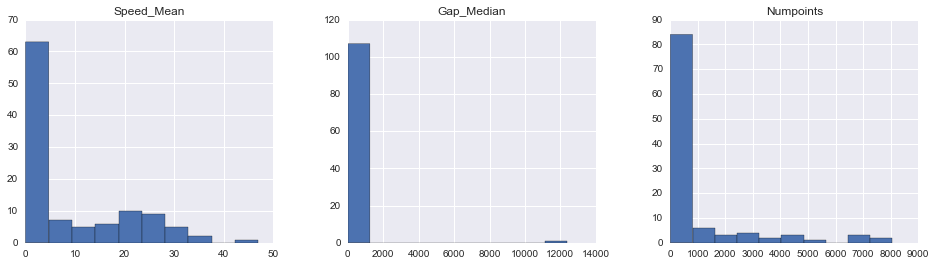

In [99]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
Baseline[['Speed_Mean']].hist(ax=ax)
ax = fig.add_subplot(132)
Baseline[['Gap_Median']].hist(ax=ax)
ax = fig.add_subplot(133)
Baseline[['Numpoints']].hist(ax=ax)


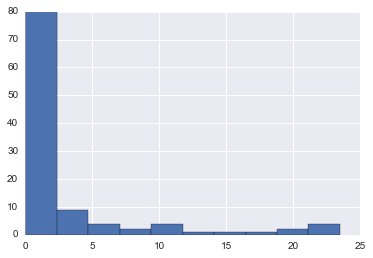

In [121]:
Baseline['Duration'].apply(lambda x: x.total_seconds()/60/60).hist()

In [23]:
dt.timedelta(days=1)

datetime.timedelta(1)

In [25]:
#Baseline: UIC Gps preprocessed Data
#GPSdata: raw Gps data with wear time fraction
#GpsDates: datetime object from Gpsdata to match with UIC data
def add_latlonwear(Baseline,Gpsdata,GpsDates):
    loc_lat = [];    loc_lon = [];     wear_frac = []
    spd_min = []; spd_max = []; spd_mean = []; spd_median = []
    duration = []; num_points = []; gap_min = [];  gap_max = []; gap_mean = []; gap_median = [] 
    

    for i in range(len(Baseline)):
        start = Baseline.BeginTime[i]
        end = Baseline.EndTime[i]
        d = Baseline.Date[i]
        
        if type(d) != str:
            d = d.strftime('%Y/%m/%d') 
        if type(start) != str:
            start = str(start)
        if type(end) != str:
            end = str(end)
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
            except(ValueError):
                try:
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
                except(ValueError):
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))


        #find matching dates between 2 files (processed and raw) and compute features
        ind = (GpsDates >= startdate) & (GpsDates <= enddate)
        # track clustered points
        if i<1:
            UsedPoints = ind
        else:
            UsedPoints = UsedPoints | ind
                
        meanLat = np.mean(Gpsdata['LATITUDE'][ind])
        meanLon = np.mean(Gpsdata['LONGITUDE'][ind])
        
        if np.isnan(meanLat) or np.isnan(meanLon):
            print('null found %s'%any(ind))
            print(startdate,enddate)
        loc_lat.append(meanLat)
        loc_lon.append(meanLon)

        spd_min.append(np.min(Gpsdata['SPEED'][ind]))
        spd_max.append(np.max(Gpsdata['SPEED'][ind]))                
        spd_mean.append(np.mean(Gpsdata['SPEED'][ind]))
        spd_median.append(np.median(Gpsdata['SPEED'][ind]))
        num_points.append(sum(ind))
        duration.append((enddate-startdate)/dt.timedelta(days=1))
        #gaps between points in secs in rawgps data for daterange
        td = GpsDates[ind].diff()
        gap_min.append(td.min().total_seconds())
        gap_max.append(td.max().total_seconds())
        gap_mean.append(td.mean().total_seconds())
        gap_median.append(td.median().total_seconds())
        
        wear_ind = (Gpsdata['Wear/Non-Wear']=='Wear') & ind
        wear_frac.append(sum(wear_ind)/sum(ind))

    Baseline['Mean Lat'] = loc_lat
    Baseline['Mean Lon'] = loc_lon
    Baseline['Wear Frac'] = wear_frac
    Baseline['Duration'] = duration; Baseline['Numpoints'] = num_points
    Baseline['Speed_Mean'] = spd_mean; Baseline['Speed_Min'] = spd_min; Baseline['Speed_Max'] = spd_max
    Baseline['Speed_Median'] = spd_median
    Baseline['Gap_Min'] = gap_min; Baseline['Gap_Max']=gap_max; Baseline['Gap_Mean']=gap_mean; 
    Baseline['Gap_Median']=gap_median

    
    print(str(sum(~UsedPoints)) + ', ' + str(sum(~UsedPoints)/len(UsedPoints)))
    # Compute Min, Max, Median, Mean of speed
    # Compute duration
    # Number of Raw GPS points
    # Min, Max, mean, std of gaps b/w points
    
    # Number of unclustered data points for each Subject-Brace

## Add Steps to UIC files

In [39]:
#Baseline: UIC Gps preprocessed Data
#GPSdata: raw Gps data with wear time fraction
#GpsDates: datetime object from Gpsdata to match with UIC data
def add_steps(Baseline,Stepsdata,StepsDates):
    steps = []; steps_per_hr = []; steps_per_wear = []
    

    for i in range(len(Baseline)):
        start = Baseline.BeginTime[i]
        end = Baseline.EndTime[i]
        d = Baseline.Date[i]
        
        if type(d) != str:
            d = d.strftime('%Y/%m/%d') 
        if type(start) != str:
            start = str(start)
        if type(end) != str:
            end = str(end)
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
            except(ValueError):
                try:
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
                except(ValueError):
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))


        #find matching dates between 2 files (processed and raw) and compute features
        ind = (StepsDates >= startdate) & (StepsDates <= enddate)
        # track clustered points
        if i<1:
            UsedPoints = ind
        else:
            UsedPoints = UsedPoints | ind
              
        stepcount = sum(Stepsdata['steps'][ind])
        dur = Baseline.Duration[i]
        wearFrac = Baseline['Wear Frac'][i]
        
        steps.append(stepcount)
        steps_per_hr.append(stepcount/dur/24)
        steps_per_wear.append(stepcount/dur/24/wearFrac)

    Baseline['Steps'] = steps
    Baseline['Steps per Hour'] = steps_per_hr
    Baseline['Steps per Hour Wear'] = steps_per_wear

    
    print(str(sum(~UsedPoints)) + ', ' + str(sum(~UsedPoints)/len(UsedPoints)))
    # Compute Min, Max, Median, Mean of speed
    # Compute duration
    # Number of Raw GPS points
    # Min, Max, mean, std of gaps b/w points
    
    # Number of unclustered data points for each Subject-Brace

In [46]:
fwt = os.listdir('Z:/C Brace/Actigraph/Data/Home/Steps Breakdown/')
fconv = os.listdir(path+'UIC_GPSData/w_Steps/')

for f in list(set(fwt)-set(fconv)):
# for f in fwt:
    try:
        #load files
        print(f)
        Stepsdata = pd.read_csv('Z:/C Brace/Actigraph/Data/Home/Steps Breakdown/'+f,skiprows=1)

        UICdata = pd.read_csv(path+'UIC_GPSData/w_LocIDandDist/'+f)
        
        #convert date formats from raw gps
        x = Stepsdata['date']+' '+Stepsdata['epoch'] #full date/time
        StepsDates = string2datetime(x) #convert to datetime object
        StepsDates=pd.Series(StepsDates)
        StepsDates=StepsDates.apply(toUTC)
                       
#         #match dates and add lat lon and weartime to UIC processed data
        add_steps(UICdata,Stepsdata,StepsDates)
        
#         #save file
        UICdata.to_csv(path+'UIC_GPSData/w_Steps/'+f)
    except(FileNotFoundError):
        print('File not found')

CBR19_Baseline.csv
5751, 0.810913705584
CBR16_Baseline.csv
File not found


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


In [44]:
StepsDates.apply(toUTC)

0        2015-09-21 19:00:00+00:00
1        2015-09-21 19:00:10+00:00
2        2015-09-21 19:00:20+00:00
3        2015-09-21 19:00:30+00:00
4        2015-09-21 19:00:40+00:00
5        2015-09-21 19:00:50+00:00
6        2015-09-21 19:01:00+00:00
7        2015-09-21 19:01:10+00:00
8        2015-09-21 19:01:20+00:00
9        2015-09-21 19:01:30+00:00
10       2015-09-21 19:01:40+00:00
11       2015-09-21 19:01:50+00:00
12       2015-09-21 19:02:00+00:00
13       2015-09-21 19:02:10+00:00
14       2015-09-21 19:02:20+00:00
15       2015-09-21 19:02:30+00:00
16       2015-09-21 19:02:40+00:00
17       2015-09-21 19:02:50+00:00
18       2015-09-21 19:03:00+00:00
19       2015-09-21 19:03:10+00:00
20       2015-09-21 19:03:20+00:00
21       2015-09-21 19:03:30+00:00
22       2015-09-21 19:03:40+00:00
23       2015-09-21 19:03:50+00:00
24       2015-09-21 19:04:00+00:00
25       2015-09-21 19:04:10+00:00
26       2015-09-21 19:04:20+00:00
27       2015-09-21 19:04:30+00:00
28       2015-09-21 

# Loop through files and add Lat, Lon and Wear Time to UIC files

In [100]:
fwt = os.listdir(path+'GPSWT/')
fconv = os.listdir(path+'UIC_GPSData/w_LatLonWear/')

for f in list(set(fwt)-set(fconv)):
    try:
        #load files
        print(f)
        Gpsdata = pd.read_csv(path+'GPSWT/'+f)
        #include long sign
        lonsgn = np.cos((Gpsdata['E/W']=='W')*np.pi)
        Gpsdata['LONGITUDE'] = Gpsdata['LONGITUDE']*lonsgn
        Subjid = f[:5]
        trial = f[6] #cbrace,SCO or baseline
        switcher = {'C':'CBR','S':'SCO','B':'Baseline'}
        UICdata = pd.read_excel(path+'UIC_GPSData/'+Subjid+'_Final_Summary_File.xlsx',sheetname=switcher[trial])
        
        #convert date formats from raw gps
        x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
        GpsDates = string2datetime(x) #convert to datetime object
        GpsDates=pd.Series(GpsDates)
                       
#         #match dates and add lat lon and weartime to UIC processed data
        add_latlonwear(UICdata,Gpsdata,GpsDates)
        
#         #save file
        UICdata.to_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    except(FileNotFoundError):
        print('File not found')

CBR22_Baseline.csv
20086, 0.387028401865


In [33]:
fconv =  os.listdir(path+'GPSWT/')

for f in fconv:
    print(f)
    Data = pd.read_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    print(len(np.unique(np.array(Data['Date']))))

CBR08_CBrace.csv
23
CBR08_SCO.csv
18
CBR11_Baseline.csv
43
CBR11_CBrace.csv
26
CBR11_SCO.csv
3
CBR15_Baseline.csv
25
CBR15_CBrace.csv
6
CBR15_SCO.csv
13
CBR16_CBrace.csv
10
CBR16_SCO.csv
17
CBR19_Baseline.csv
2
CBR19_CBrace.csv
2
CBR19_SCO.csv
2
CBR21_Baseline.csv
31
CBR21_CBrace.csv
22
CBR21_SCO.csv
23
CBR22_Baseline.csv
11
CBR22_CBrace.csv
17
CBR22_SCO.csv
4
CBR24_Baseline.csv
33
CBR24_CBrace.csv
29
CBR24_SCO.csv
18
CBR25_Baseline.csv
29
CBR25_CBrace.csv
36
CBR26_Baseline.csv
34
CBR26_CBrace.csv
34
CBR26_SCO.csv
29
CBR27_Baseline.csv
24
CBR27_CBrace.csv
16
CBR27_SCO.csv
34
CBR28_Baseline.csv
31
CBR28_CBrace.csv
28
CBR28_SCO.csv
30
CBR30_Baseline.csv
30
CBR30_CBrace.csv
29
CBR30_SCO.csv
15
CBR31_Baseline.csv
16
CBR31_CBrace.csv
21
CBR31_SCO.csv
32


# Load Files and aggregate per brace

In [3]:
path_procfiles = os.path.join(path,'UIC_GPSData/w_Steps')

In [4]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        Data = pd.concat([Data,d]) #concatenate data from each subj
    else:
        #skip directories
        continue

In [5]:
cols=list((Data.columns).values)
cols.remove('SubjID')
cols.remove('Brace')
Data = Data[['SubjID','Brace']+cols]
Data['LandUse'] = Data.LandUse.astype(str)
# Data['BeginTime']= Data[['BeginTime']].applymap(lambda x: dt.datetime.strptime(x,'%H:%M:%S').time())
# Data['EndTime']= Data[['EndTime']].applymap(lambda x: dt.datetime.strptime(x,'%H:%M:%S').time())
Data.head()

,SubjID,Brace,BeginTime,Date,DistHome,Duration,EndTime,Gap_Max,Gap_Mean,Gap_Median,...,Speed_Max,Speed_Mean,Speed_Median,Speed_Min,Steps,Steps per Hour,Steps per Hour Wear,TotalGap,Unnamed: 0.1.1,Wear Frac
0,CBR21,Cbr,15:18:57,2016-08-18,5442.413371,0.024306,15:53:57,1850.0,80.769231,10.0,...,7.152199,0.527363,0.171908,0.000000,120,205.714286,205.714286,90.916667,0,1.000000
1,CBR21,Cbr,15:54:07,2016-08-18,-1.000000,0.017824,16:19:47,10.0,10.000000,10.0,...,89.653122,33.155807,29.719219,0.012541,1,2.337662,2.337662,0.000000,1,1.000000
2,CBR21,Cbr,16:19:57,2016-08-18,12229.512267,0.115509,19:06:17,10.0,9.989990,10.0,...,16.163797,0.215601,0.079174,0.005376,0,0.000000,0.000000,0.000000,2,0.015000
3,CBR21,Cbr,19:06:27,2016-08-18,-1.000000,0.011921,19:23:37,10.0,10.000000,10.0,...,73.872200,35.997711,40.192213,0.032327,4,13.980583,13.980583,0.000000,3,1.000000
4,CBR21,Cbr,19:23:47,2016-08-18,6302.016284,0.073264,21:09:17,10.0,10.000000,10.0,...,2.244580,0.230411,0.080916,0.004430,0,0.000000,0.000000,0.000000,4,0.063091


## Anonymize home location

In [8]:
# Data.loc[Data.LandUse=='Home','Mean Lat'] = 41.8938732
# Data.loc[Data.LandUse=='Home','Mean Lon'] = -87.6209879
# Data[Data.LandUse=='Home']['Mean Lon'].unique()

In [72]:
#save anonymzed data
# Data.to_csv(os.path.join(path+'UIC_GPSData/w_LatLonWear/','Anonymzed/AnonymzedData.csv'))

Data = pd.read_csv('AnonymzedData.csv')

## Data cleaning

In [50]:
landuse=Data[['LandUse']]
landuse=landuse.applymap(lambda x: str.capitalize(x))
Data['LandUse'] = landuse

In [51]:
c = Data.LandUse.value_counts(normalize=True)
c[:10]

Trip                   0.449575
Home                   0.212102
Com_urbmix             0.123557
Com_regional           0.046683
Res_sf_detached        0.040213
Res_mf                 0.024610
Non-parcel road row    0.016618
Com_bigbox             0.012812
Com_office             0.011417
Inst_medical           0.008372
Name: LandUse, dtype: float64

In [52]:
sum(c[:3]) #top 3 locs account for most data

0.78523404795128759

In [53]:
Data.LandUse = [x.split('_')[0] for x in Data.LandUse]

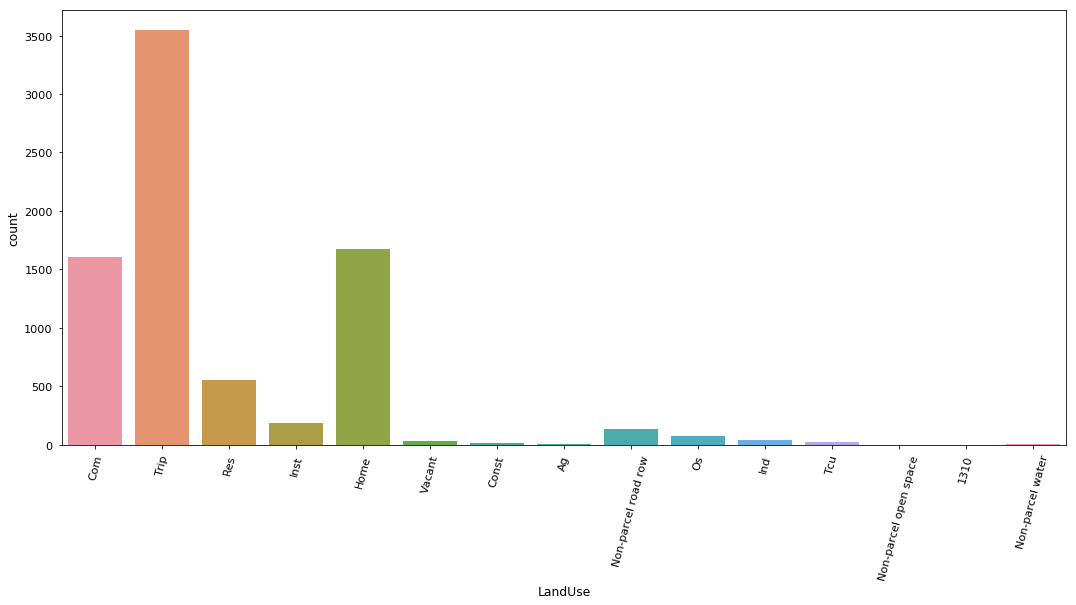

In [54]:
sns.set_context('paper',font_scale=1.4)
plt.figure(figsize=(18,8))
ax = sns.countplot(Data.LandUse)
ax = plt.xticks(rotation=75)

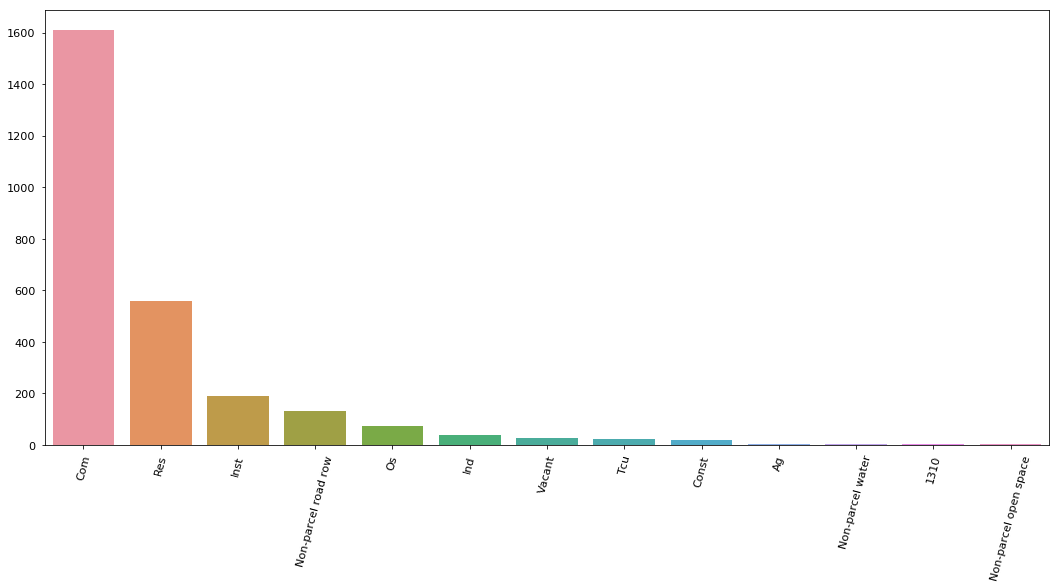

In [55]:
c = Data.LandUse.value_counts(normalize=False)
sns.set_context('paper',font_scale=1.4)
plt.figure(figsize=(18,8))
sns.barplot(x=c[2:].index,y=c[2:].values)
ax = plt.xticks(rotation=75)

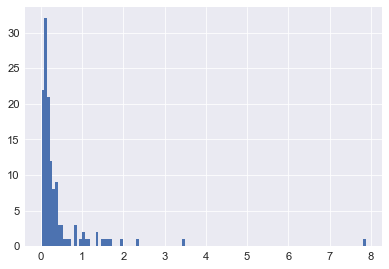

In [94]:
(Data[Data['LandUse']=='Non-parcel road row']['Duration']*24).hist(bins=120)

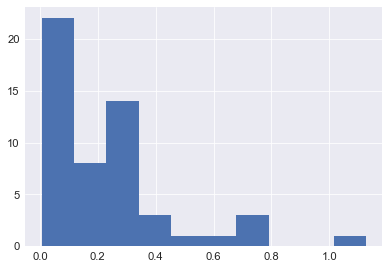

In [103]:
(Data[Data['Mode']=='Walk']['Duration']*24).hist()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010FDAE80>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000015806588>], dtype=object)

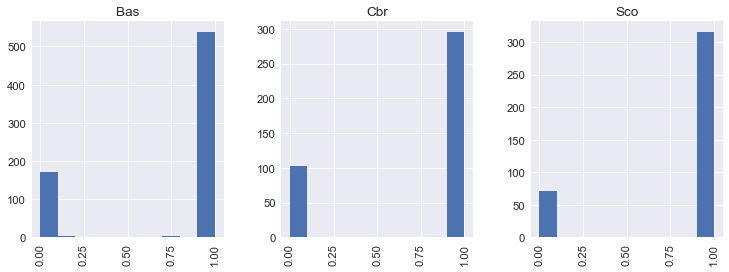

In [42]:
LocData = Data[(Data['LandUse']=='Com')]
LocData.hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C49E9B0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001318F160>], dtype=object)

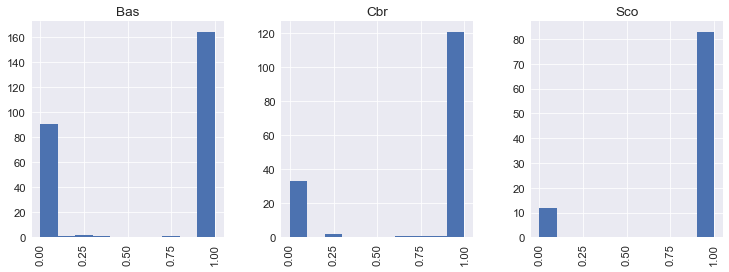

In [43]:
Data[(Data['LandUse']=='Res')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010915438>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000CDAE470>], dtype=object)

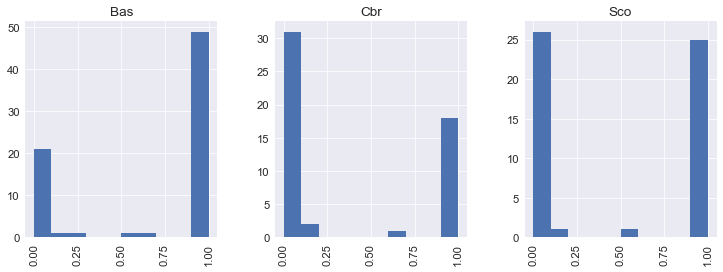

In [44]:
Data[(Data['LandUse']=='Inst')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012D8C6D8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D321A90>], dtype=object)

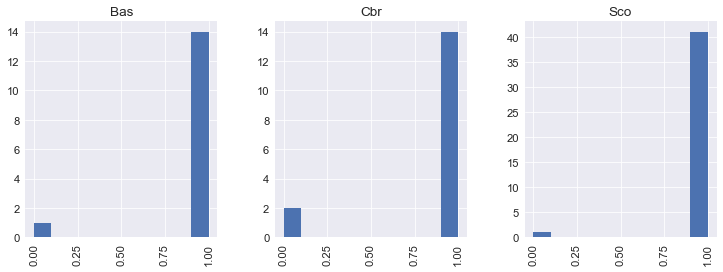

In [45]:
Data[(Data['LandUse']=='Os')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

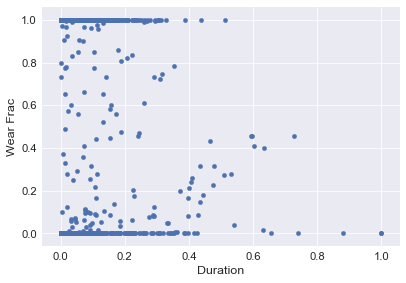

In [54]:
BraceData = Data[(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip')&(Data['Brace']=='Cbr'))]
ax = BraceData.plot(x='Duration',y='Wear Frac',kind='scatter')
# ax.set_xlim(-.1,10)

# Calculate Features

In [6]:
path_procfiles = os.path.join(path,'UIC_GPSData/w_Steps')

In [7]:
def getTripDur(PreDestInd,Data):
    d = Data[PreDestInd]
    TripDur=[]
    for i in range(len(d)):
        if d['LandUse'].as_matrix()[i]=='Trip':
            TripDur.append(d['Duration'].as_matrix()[i])
        else:
            TripDur.append(np.float('nan'))
            
    return pd.Series(TripDur)

**Retrieve Home Data only**

In [8]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        d.LandUse = [x.split('_')[0] for x in d.LandUse]
        DestinationInd = d['LandUse']=='Home' #to retrieve home data
        # don't use first row as a destination
        if DestinationInd[0]:
            DestinationInd[0] = False
        
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        d = d[DestinationInd]
        Data = pd.concat([Data,d]) #concatenate data from each subj 
    else:
        #skip directories
        continue

In [9]:
Data=Data.drop('Unnamed: 0.1.1',axis=1)
Data.columns

Index(['BeginTime', 'Brace', 'Date', 'DistHome', 'Duration', 'EndTime',
       'Gap_Max', 'Gap_Mean', 'Gap_Median', 'Gap_Min', 'LandUse', 'LocID',
       'MaximumSpeed', 'Mean Lat', 'Mean Lon', 'MeanSpeed', 'MinimumSpeed',
       'Mode', 'Numberpoints', 'Numpoints', 'Sequence', 'Speed_Max',
       'Speed_Mean', 'Speed_Median', 'Speed_Min', 'Steps', 'Steps per Hour',
       'Steps per Hour Wear', 'SubjID', 'TotalGap', 'Wear Frac'],
      dtype='object')

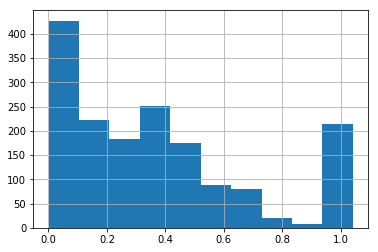

In [10]:
Data['Duration'].hist()

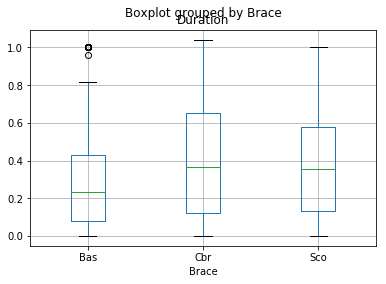

In [11]:
Data.boxplot(column='Duration',by='Brace')

In [12]:
#assign new brace category
Data['NewBrace']=0

In [13]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Sco' 'Bas']
CBR30 ['Bas' 'Cbr' 'Sco']
CBR22 ['Cbr' 'Sco' 'Bas']
CBR24 ['Sco' 'Cbr' 'Bas']
CBR27 ['Sco' 'Bas' 'Cbr']
CBR26 ['Bas' 'Cbr' 'Sco']
CBR11 ['Cbr' 'Bas' 'Sco']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas' 'Sco']
CBR31 ['Sco' 'Bas' 'Cbr']
CBR15 ['Cbr' 'Bas' 'Sco']
CBR19 ['Sco' 'Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']


In [14]:
Data=Data.reset_index(drop=True)
#add label of new brace
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1
    else: #if only SCO or Cbr data exists
        if 'Cbr' in Data[Data['SubjID']==s].Brace.unique():
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1    
        else:
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1    
            

In [15]:
#To remove SCO data (for speed analysis) if 3 devices exist
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        inds= np.where((Data['SubjID']==s) & (Data['Brace']=='Sco'))[0]
        Data=Data.drop(inds)
        Data=Data.reset_index(drop=True)
len(Data)  

1303

In [16]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Bas']
CBR30 ['Bas' 'Cbr']
CBR22 ['Cbr' 'Bas']
CBR27 ['Bas' 'Cbr']
CBR26 ['Bas' 'Cbr']
CBR11 ['Cbr' 'Bas']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas']
CBR15 ['Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR19 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']
CBR24 ['Cbr' 'Bas']
CBR31 ['Bas' 'Cbr']


In [17]:
Features = pd.DataFrame({'Wear Frac':np.array(Data['Wear Frac'])})

In [18]:
Features['Duration'] = (Data['Duration']*24).as_matrix()
Features['Mean Speed'] = Data['Speed_Mean'].as_matrix()
Features['SubjID'] = Data['SubjID'].as_matrix()
Features['NewBrace'] = Data['NewBrace'].as_matrix()
Features['LocID'] = Data['LocID'].as_matrix()
Features['Steps'] = Data['Steps'].as_matrix()
Features['Steps per Hour'] = Data['Steps per Hour'].as_matrix()
Features['Steps per Hour Wear'] = Data['Steps per Hour Wear'].as_matrix()
Features['Date'] = Data['Date'].as_matrix()

In [19]:
demographics = pd.read_excel('./Demographics_analysis.xlsx')
Features['Age'] = [demographics[demographics['SubjID']==x]['Age'].values[0] for x in Data['SubjID']]
Features['Diagnosis'] = [demographics[demographics['SubjID']==x]['Short Diagnosis'].values[0] for x in Data['SubjID']]
Features['BaselineYrs'] = [demographics[demographics['SubjID']==x]['y of baseline use'].values[0] for x in Data['SubjID']]
ClinicalMeasures = ['6mwt', '10mwt_ss', '10mwt_fast']
for name in ClinicalMeasures:
    d = pd.read_csv('./Clinical Measures/'+name+'.csv')
    Features[name] = [d[d['SubjID']==x][y].values[0] for x, y in Data[['SubjID', 'Brace']].as_matrix()]

In [20]:
Features.to_csv('GPSandClinicalData_Home.csv',index=False)

In [72]:
Data.columns

Index(['BeginTime', 'Brace', 'Date', 'DistHome', 'Duration', 'EndTime',
       'Gap_Max', 'Gap_Mean', 'Gap_Median', 'Gap_Min', 'LandUse', 'LocID',
       'MaximumSpeed', 'Mean Lat', 'Mean Lon', 'MeanSpeed', 'MinimumSpeed',
       'Mode', 'Numberpoints', 'Numpoints', 'Sequence', 'Speed_Max',
       'Speed_Mean', 'Speed_Median', 'Speed_Min', 'SubjID', 'TotalGap',
       'Wear Frac', 'NewBrace'],
      dtype='object')

**Retrieve Destinations data only**

In [92]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        d.LandUse = [x.split('_')[0] for x in d.LandUse]
        DestinationInd = (d['LandUse']!='Home')&(d['LandUse']!='Trip')
        # don't use first row as a destination
        if DestinationInd[0]:
            DestinationInd[0] = False
        
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        
#         print(sum(DestinationInd), sum(d['LandUse']=='Trip'))
        
        # Calculate trip features
        PreDestInd = DestinationInd[1::]
        PreDestInd = PreDestInd.append(pd.Series(False)).as_matrix()
#         print(d[PreDestInd]['LandUse'].unique())

#         TripMode = pd.Series(np.float('nan')).append(d[PreDestInd]['Mode'])
        TripMode = d[PreDestInd]['Mode']
#         TripDuration = pd.Series(np.float('nan')).append(getTripDur(PreDestInd,d))
        TripDuration = getTripDur(PreDestInd,d)
        
        # Calculate aggregate features
        d = d[DestinationInd]
        d['Relative Freq'] = pd.Series([sum(d['LocID']==x)/sum(DestinationInd) for x in d['LocID']]).as_matrix()
        d['Relative Duration'] = pd.Series([sum(d[d['LocID']==x]['Duration'])/sum(d['Duration']) for x in d['LocID']]).as_matrix()
#         print(np.sum(np.unique(d['Relative Duration'])))
        d['TripMode'] = TripMode.as_matrix()
        d['TripDuration'] = TripDuration.as_matrix()
        Data = pd.concat([Data,d]) #concatenate data from each subj
    else:
        #skip directories
        continue

OtherDestInd = (Data['LandUse']!='Inst')&(Data['LandUse']!='Res')&(Data['LandUse']!='Com')&(Data['LandUse']!='Os')
Data.loc[OtherDestInd,'LandUse'] = 'Other'

In [93]:
newbrace = 'Cbr'
for s in Data.SubjID.unique():
    Data_ = Data[(Data['SubjID']==s)&(Data['Brace']==newbrace)]
    print(s,np.sum(np.unique(Data_['Relative Duration'])),len(np.unique(Data_['Relative Duration'])), len(np.unique(Data_['LocID'])))


CBR21 1.0 39 39
CBR30 0.997640757508 82 83
CBR22 0.999185655695 28 29
CBR24 1.0 20 20
CBR27 0.0 0 0
CBR26 0.990781177716 30 33
CBR11 0.996556359807 52 57
CBR16 0.997422727858 30 31
CBR28 1.0 4 4
CBR31 0.995418374729 19 20
CBR15 1.0 11 11
CBR19 1.0 4 4
CBR25 1.0 12 12
CBR08 0.992913777914 24 25


In [94]:
Data.columns

Index(['BeginTime', 'Brace', 'Date', 'DistHome', 'Duration', 'EndTime',
       'Gap_Max', 'Gap_Mean', 'Gap_Median', 'Gap_Min', 'LandUse', 'LocID',
       'MaximumSpeed', 'Mean Lat', 'Mean Lon', 'MeanSpeed', 'MinimumSpeed',
       'Mode', 'Numberpoints', 'Numpoints', 'Relative Duration',
       'Relative Freq', 'Sequence', 'Speed_Max', 'Speed_Mean', 'Speed_Median',
       'Speed_Min', 'Steps', 'Steps per Hour', 'Steps per Hour Wear', 'SubjID',
       'TotalGap', 'TripDuration', 'TripMode', 'Unnamed: 0.1.1', 'Wear Frac'],
      dtype='object')

In [95]:
Data.Sequence.unique()

array([ 3,  5,  7, 11,  9, 13,  1, 15,  6,  8, 10, 12, 14,  2,  4, 16, 18,
       20, 22, 17, 19, 21, 23, 25, 29, 27, 31, 35, 33, 37, 39, 26, 28, 30,
       32, 34, 36, 40, 44, 41, 43, 45, 47, 49, 24, 38], dtype=int64)

In [96]:
Datacopy = Data.copy()

In [97]:
Data=Datacopy.copy()

In [98]:
Data=Data.reset_index(drop=True)
Data.head()
print(len(Data))

2653


In [99]:
#assign new brace category
Data['NewBrace']=0

In [100]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Sco' 'Bas']
CBR30 ['Bas' 'Cbr' 'Sco']
CBR22 ['Cbr' 'Sco' 'Bas']
CBR24 ['Sco' 'Cbr' 'Bas']
CBR27 ['Sco' 'Bas']
CBR26 ['Bas' 'Cbr' 'Sco']
CBR11 ['Cbr' 'Bas' 'Sco']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas' 'Sco']
CBR31 ['Sco' 'Bas' 'Cbr']
CBR15 ['Cbr' 'Bas' 'Sco']
CBR19 ['Sco' 'Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']


In [101]:
#add label of new brace
for s in Data.SubjID.unique():
#     print(Data[Data['SubjID']==s].Brace.unique())
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1
    else: #if only SCO or Cbr data exists
        if 'Cbr' in Data[Data['SubjID']==s].Brace.unique():
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1    
        else:
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1    
            

In [102]:
#To remove SCO data (for speed analysis) if 3 devices exist
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        inds= np.where(((Data['SubjID']==s) & (Data['Brace']=='Sco')))[0]
        Data=Data.drop(inds)
        Data=Data.reset_index(drop=True)
len(Data)  

2181

In [103]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Bas']
CBR30 ['Bas' 'Cbr']
CBR22 ['Cbr' 'Bas']
CBR27 ['Sco' 'Bas']
CBR26 ['Bas' 'Cbr']
CBR11 ['Cbr' 'Bas']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas']
CBR15 ['Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR19 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']
CBR24 ['Cbr' 'Bas']
CBR31 ['Bas' 'Cbr']


In [104]:
Data.to_csv('GPSData.csv',index=False)

In [105]:
Features = pd.DataFrame({'Wear Frac':np.array(Data['Wear Frac'])})

In [107]:
Features['DestinationType'] = Data['LandUse'].as_matrix()
Features['Distance'] = (Data['DistHome']/1000).as_matrix()
Features['Duration'] = (Data['Duration']*24).as_matrix()
Features['Mean Speed'] = Data['Speed_Mean'].as_matrix()
# Features['TripMode'] = Data['TripMode'].as_matrix()
Features['TripDuration'] = Data['TripDuration'].as_matrix()
Features['Relative_Freq'] = Data['Relative Freq'].as_matrix()
Features['Relative_Duration'] = Data['Relative Duration'].as_matrix()
Features['SubjID'] = Data['SubjID'].as_matrix()
# Features['Brace'] = Data['Brace'].as_matrix()
Features['NewBrace'] = Data['NewBrace'].as_matrix()
Features['Steps'] = Data['Steps'].as_matrix()
Features['Steps per Hour'] = Data['Steps per Hour'].as_matrix()
Features['Steps per Hour Wear'] = Data['Steps per Hour Wear'].as_matrix()

In [108]:
demographics = pd.read_excel('./Demographics_analysis.xlsx')
demographics.columns

Index(['SubjID', 'median WT CBR', 'median WT SCO', 'median WT Baseline',
       'med sph CBR', 'med sph SCO', 'med sph Baseline', 'y of baseline use',
       'Diagnosis', 'Short Diagnosis', 'Age', 'Ncluster CBR',
       'MeanAwayTime CBR', 'Away/Home Time CBR', 'Home_WT CBR', 'Away_WT CBR',
       'Ncluster SCO', 'MeanAwayTime SCO', 'Away/Home Time SCO', 'Home_WT SCO',
       'Away_WT SCO'],
      dtype='object')

In [117]:
Features['Age'] = [demographics[demographics['SubjID']==x]['Age'].values[0] for x in Data['SubjID']]
Features['Diagnosis'] = [demographics[demographics['SubjID']==x]['Short Diagnosis'].values[0] for x in Data['SubjID']]
Features['BaselineYrs'] = [demographics[demographics['SubjID']==x]['y of baseline use'].values[0] for x in Data['SubjID']]


In [110]:
ClinicalMeasures = ['6mwt', '10mwt_ss', '10mwt_fast']
for name in ClinicalMeasures:
    d = pd.read_csv('./Clinical Measures/'+name+'.csv')
    Features[name] = [d[d['SubjID']==x][y].values[0] for x, y in Data[['SubjID', 'Brace']].as_matrix()]

In [111]:
#threshold max distance and bin age
Features.loc[Features['Distance']>1000,'Distance'] = 1000
#bin age
bins = [0, 30, 64, 80]
group_names = ['0-30', '30-64', '64+']
Age_binned = pd.cut(Features['Age'], bins, labels=group_names)
Features['Age']=Age_binned
pd.value_counts(Features['Age'],normalize=True)

30-64    0.756534
64+      0.202659
0-30     0.040807
Name: Age, dtype: float64

In [112]:
#convert nan to unknown category for Tripmode
# ind = Features['TripMode'].isnull()
# Features.loc[ind,'TripMode']='unknown'

In [113]:
#conver wear frac to binary 
# Features.loc[Features['Wear Frac']>.5,'Wear Frac'] = 1
# Features.loc[Features['Wear Frac']<.5,'Wear Frac'] = 0

In [114]:
#add lat and lon
Features['Mean Lat'] = Data['Mean Lat'].as_matrix()
Features['Mean Lon'] = Data['Mean Lon'].as_matrix()
Features['LocID'] = Data['LocID'].as_matrix()

In [115]:
Features.head()

,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,SubjID,NewBrace,...,Steps per Hour Wear,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast,Mean Lat,Mean Lon,LocID
0,0.015000,Res,12.229512,2.772222,0.215601,0.017824,0.014925,0.021452,CBR21,1,...,0.0,64+,poliomyelitis,60.0,231.93,0.69,0.85,41.732207,-88.132441,2
1,0.063091,Inst,6.302016,1.758333,0.230411,0.011921,0.014925,0.013607,CBR21,1,...,0.0,64+,poliomyelitis,60.0,231.93,0.69,0.85,41.783632,-88.188553,3
2,0.000000,Com,5.095353,1.016389,0.591493,0.008218,0.014925,0.007865,CBR21,1,...,NaN,64+,poliomyelitis,60.0,231.93,0.69,0.85,41.765985,-88.206360,4
3,0.000000,Com,5.172335,0.366111,1.607549,0.001505,0.029851,0.004252,CBR21,1,...,NaN,64+,poliomyelitis,60.0,231.93,0.69,0.85,41.760925,-88.208135,5
4,0.000000,Com,2.871296,0.052778,4.483316,0.003704,0.044776,0.001827,CBR21,1,...,NaN,64+,poliomyelitis,60.0,231.93,0.69,0.85,41.760981,-88.242395,6


In [118]:
Features.to_csv('GPSandClinicalData.csv',index=False)

In [94]:
len(Features)

2181

In [303]:
#use only data from new brace
# Features = Features[Features['NewBrace']==1]
# len(Features)

In [304]:
#save features
Features.to_csv('GPSmodelFeatures_2braceonly.csv',index=False)

# Explore features

In [305]:
#load features
# Features = pd.read_csv('GPSmodelFeatures.csv')
Features = pd.read_csv('GPSmodelFeatures_2braceonly.csv')
Features.head()

,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,SubjID,NewBrace,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast
0,0.0,Inst,6.302016,1.758333,0.230411,0.011921,0.014925,0.013607,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85
1,0.0,Com,5.095353,1.016389,0.591493,0.008218,0.014925,0.007865,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85
2,0.0,Com,5.172335,0.366111,1.607549,0.001505,0.029851,0.004252,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85
3,0.0,Com,2.871296,0.052778,4.483316,0.003704,0.044776,0.001827,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85
4,0.0,Com,2.870687,0.033333,7.098997,0.004514,0.044776,0.001827,CBR21,1,64+,poliomyelitis,60.0,231.93,0.69,0.85


### Does Clinical speed (10mWT) affect wear time and role of brace

In [306]:
F = Features[['SubjID','NewBrace','10mwt_ss','Wear Frac']]

In [307]:
F.head()

,SubjID,NewBrace,10mwt_ss,Wear Frac
0,CBR21,1,0.69,0.0
1,CBR21,1,0.69,0.0
2,CBR21,1,0.69,0.0
3,CBR21,1,0.69,0.0
4,CBR21,1,0.69,0.0


In [309]:
Wf = pd.DataFrame(data=None,columns=['SubjID','NewBrace','Avg_WearFrac','10mwt_ss'])
for s in F.SubjID.unique():
    for brace in F.NewBrace.unique():
               
        d_s = F.loc[(F['SubjID']==s) & (F['NewBrace']==brace),['Wear Frac','10mwt_ss']]
        wf_s = d_s['Wear Frac'].values
        wf_s = np.sum(wf_s)/len(wf_s) #compute average wear time fraction over all locations
    
        d = {'SubjID':s, 'NewBrace':brace ,'Avg_WearFrac':wf_s, '10mwt_ss':d_s['10mwt_ss'].unique()}
     
        Wf=Wf.append(pd.DataFrame(d),ignore_index=True) 
    

In [313]:
Wf.head()

,10mwt_ss,Avg_WearFrac,NewBrace,SubjID
0,0.69,0.030303,1,CBR21
1,0.70,0.630952,0,CBR21
2,1.20,0.936416,1,CBR30
3,0.99,0.983607,0,CBR30
4,1.00,0.840000,1,CBR22


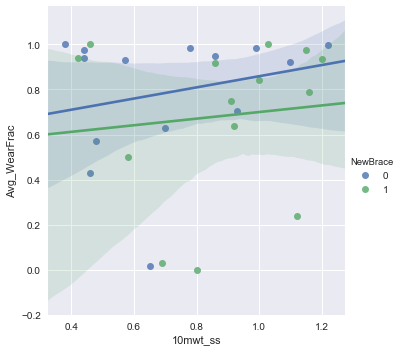

In [311]:
sns.lmplot(data=Wf,x='10mwt_ss',y='Avg_WearFrac',hue='NewBrace') #binarized weartime

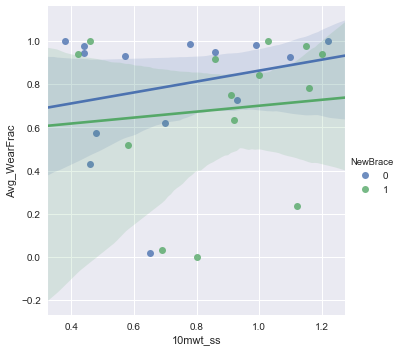

In [284]:
sns.lmplot(data=Wf,x='10mwt_ss',y='Avg_WearFrac',hue='NewBrace')

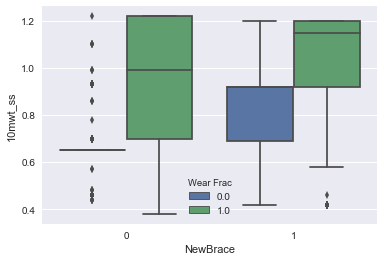

In [312]:
sns.boxplot(data=F,x='NewBrace',y='10mwt_ss',hue='Wear Frac')

## Explore features

In [6]:
Features.columns

Index(['Wear Frac', 'DestinationType', 'Distance', 'Duration', 'Mean Speed',
       'TripDuration', 'Relative_Freq', 'Relative_Duration', 'SubjID',
       'NewBrace', 'Age', 'Diagnosis', 'BaselineYrs', '6mwt', '10mwt_ss',
       '10mwt_fast'],
      dtype='object')

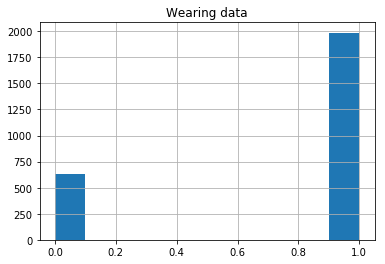

In [7]:
Features['Wear Frac'].hist()
plt.title('Wearing data')

In [8]:
np.sort(Features[Features['Wear Frac']==0].SubjID.unique())

array(['CBR08', 'CBR11', 'CBR15', 'CBR19', 'CBR21', 'CBR22', 'CBR24',
       'CBR25', 'CBR26', 'CBR27', 'CBR28', 'CBR30', 'CBR31'], dtype=object)

In [9]:
#instances for each subject having wear frac = 0
for s in np.sort(Features[Features['Wear Frac']==0].SubjID.unique()):

    print(s,len(Features[(Features['SubjID']==s) & (Features['Wear Frac']==0)]))#/len(Features[Features['SubjID']==s]))

CBR08 51
CBR11 324
CBR15 16
CBR19 5
CBR21 156
CBR22 20
CBR24 23
CBR25 2
CBR26 3
CBR27 1
CBR28 3
CBR30 14
CBR31 11


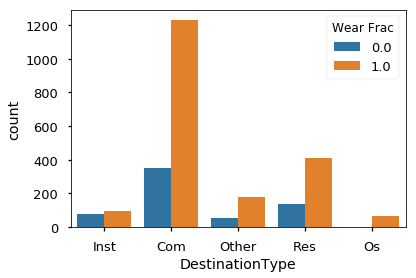

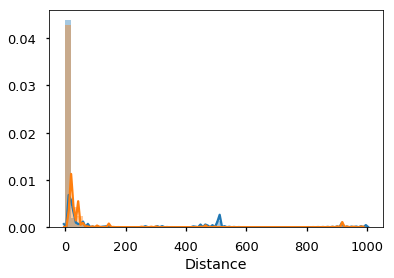

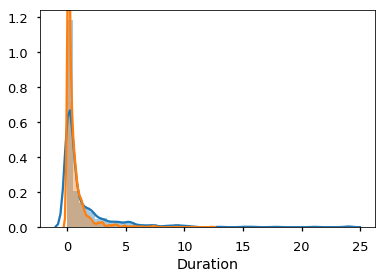

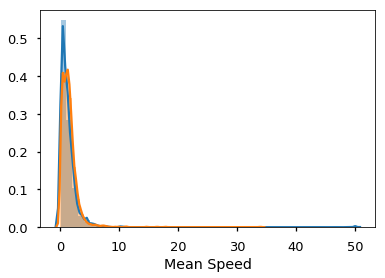

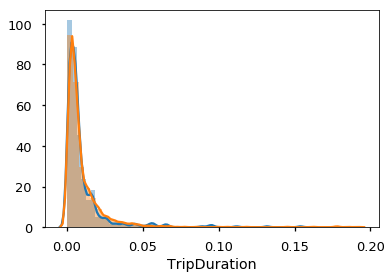

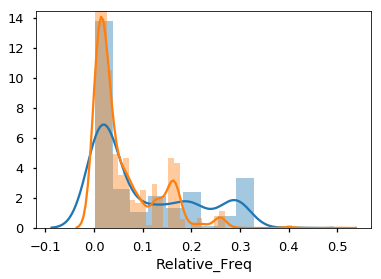

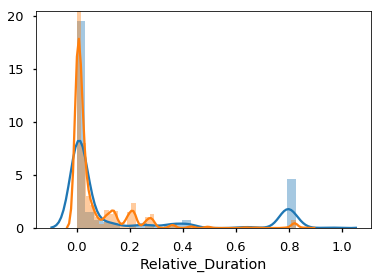

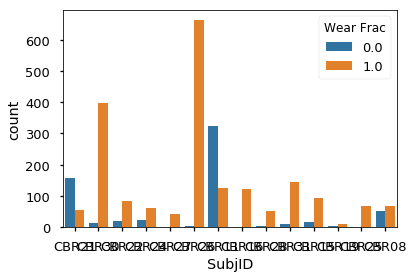

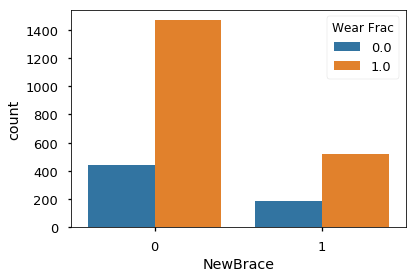

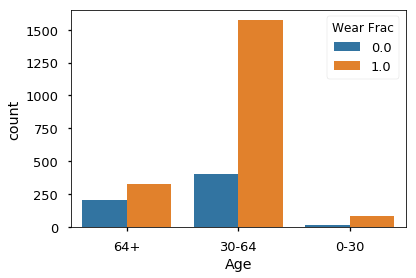

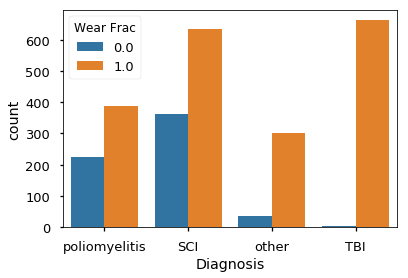

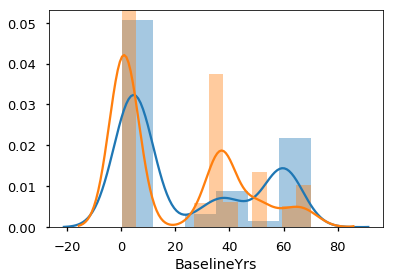

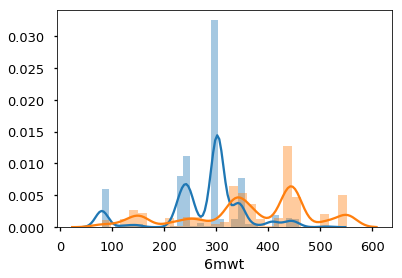

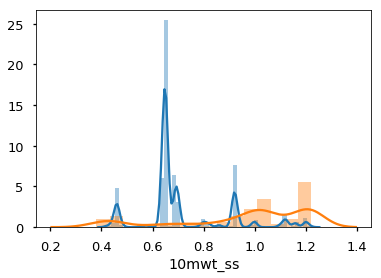

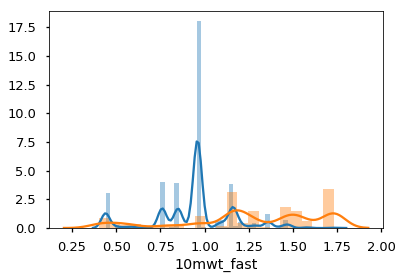

In [13]:
sns.set_context('talk')
f = Features.columns.values
f = list(f)[1:]
dtypesf = list(Features.dtypes[1:]) 
ft = zip(f,dtypesf)

for feat,ftyp in ft:
    fig = plt.figure()
    if ftyp is np.dtype('float64'):
        ind = ~(Features.loc[Features['Wear Frac']==0,feat].isnull()) #non-null values
        sns.distplot(Features[Features['Wear Frac']==0][ind][feat])
        ind = ~(Features.loc[Features['Wear Frac']==1,feat].isnull()) #non-null values
        sns.distplot(Features[Features['Wear Frac']==1][ind][feat])
#         sns.distplot(Features.loc[Features['Wear Frac']==0,feat])
#         sns.distplot(Features.loc[Features['Wear Frac']==1,feat])
# #         ax = Features.hist(column=feat,by='Wear Frac',layout=(1,2))
#         ax[0].set_xlabel(feat)
    else:
        sns.countplot(data=Features,x=feat,hue='Wear Frac')
    

# Train model

1) xgb – this is the direct xgboost library. I will use a specific function “cv” from this library

2) XGBClassifier – this is an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM

XGB package intro http://xgboost.readthedocs.io/en/latest/python/python_intro.html

Python API https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting

Feature importance example (in R) http://xgboost.readthedocs.io/en/latest/R-package/discoverYourData.html#feature-importance


## convert categorical vars into numeric ones using one-hot encoding
* Alternatively we could use [numerical vals conversion](https://chrisalbon.com/machine-learning/convert_pandas_categorical_column_into_integers_for_scikit-learn.html)

In [6]:
#drop SubjID from features table
cols = list(Features.columns)
cols.remove('SubjID')
SubjID = Features.SubjID
Features = Features.drop('SubjID',axis=1)

In [7]:
# # #convert using numerical encoding
FeaturesNum = Features.copy()
from sklearn.preprocessing import LabelEncoder
# Create a label (category) encoder object
enc = LabelEncoder()
cat_cols=Features.columns[(Features.dtypes == object) | (Features.dtypes == 'category')]
for c in cat_cols:
    FeaturesNum[c] = enc.fit_transform(FeaturesNum[c])
    print(c,np.unique(FeaturesNum[c]),enc.inverse_transform(np.unique(FeaturesNum[c])))

FeaturesNum.head()

DestinationType [0 1 2 3 4] ['Com' 'Inst' 'Os' 'Other' 'Res']
Age [0 1 2] ['0-30' '30-64' '64+']
Diagnosis [0 1 2 3] ['SCI' 'TBI' 'other' 'poliomyelitis']


,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,NewBrace,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast
0,0.0,1,6.302016,1.758333,0.230411,0.011921,0.014925,0.013607,1,2,3,60.0,231.93,0.69,0.85
1,0.0,0,5.095353,1.016389,0.591493,0.008218,0.014925,0.007865,1,2,3,60.0,231.93,0.69,0.85
2,0.0,0,5.172335,0.366111,1.607549,0.001505,0.029851,0.004252,1,2,3,60.0,231.93,0.69,0.85
3,0.0,0,2.871296,0.052778,4.483316,0.003704,0.044776,0.001827,1,2,3,60.0,231.93,0.69,0.85
4,0.0,0,2.870687,0.033333,7.098997,0.004514,0.044776,0.001827,1,2,3,60.0,231.93,0.69,0.85


In [8]:
# # #convert using one-hot encoding
# FeaturesNum = pd.get_dummies(Features)
# FeaturesNum.head()

In [9]:
FeaturesNum.columns

Index(['Wear Frac', 'DestinationType', 'Distance', 'Duration', 'Mean Speed',
       'TripDuration', 'Relative_Freq', 'Relative_Duration', 'NewBrace', 'Age',
       'Diagnosis', 'BaselineYrs', '6mwt', '10mwt_ss', '10mwt_fast'],
      dtype='object')

In [10]:
target = 'Wear Frac'
predictors = [x for x in FeaturesNum.columns if x not in target]

In [11]:
len(predictors)

14

## Features correlation (numerical)

In [12]:
Features[predictors].dtypes

DestinationType       object
Distance             float64
Duration             float64
Mean Speed           float64
TripDuration         float64
Relative_Freq        float64
Relative_Duration    float64
NewBrace               int64
Age                   object
Diagnosis             object
BaselineYrs          float64
6mwt                 float64
10mwt_ss             float64
10mwt_fast           float64
dtype: object

In [13]:
fnum = Features.drop(['NewBrace','Diagnosis','DestinationType','Age'],axis=1)

In [14]:
fnum = fnum.apply(lambda x: (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))  )

In [47]:
fcorr=fnum.corr()

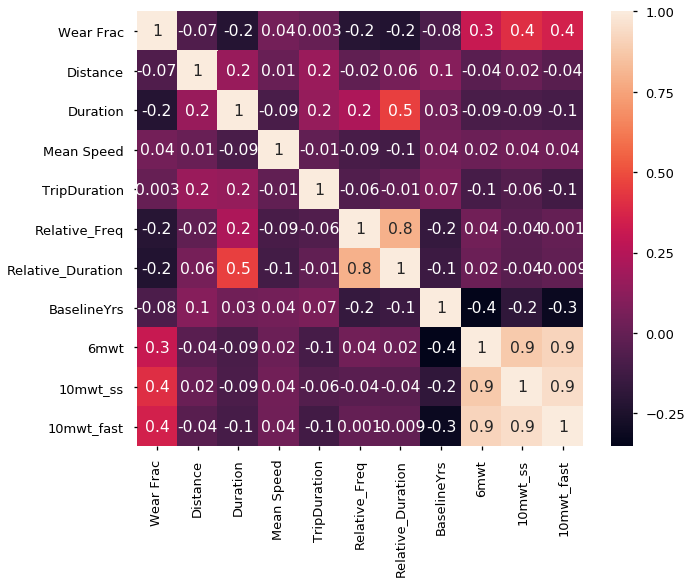

In [60]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(fcorr,annot=True,fmt='.1g')

### k-fold CV

In [35]:
#stratified split into train and test set
X_train,X_test,y_train,y_test = train_test_split(FeaturesNum[predictors],FeaturesNum[target],
                                                 test_size=0.33,random_state=32)

In [36]:
X_train[target]=y_train

In [37]:
#5-fold CV
def modelfit(alg, dtrain, predictors, target, usetrainCV=True, cv_folds=5, early_stop_rounds=50):
    
    if usetrainCV:
        xgb_param=alg.get_xgb_params()
        
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,  
                          metrics='auc', early_stopping_rounds=early_stop_rounds,verbose_eval=False)
        
        alg.set_params(n_estimators=cvresult.shape[0])
            
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Wear Frac'],eval_metric='auc')
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #display
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(dtrain['Wear Frac'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Wear Frac'], dtrain_predprob))
    print('Optimal N trees = %d'%alg.get_booster().best_ntree_limit)
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')  
    
    return feat_imp

Accuracy (Train) : 0.9389
AUC Score (Train): 0.983380
Optimal N trees = 76


10mwt_ss                   75
BaselineYrs                59
Duration                   58
Mean Speed                 47
Distance                   47
6mwt                       36
NewBrace                   26
Relative Duration          25
TripDuration               24
10mwt_fast                 24
Relative Freq              20
Age_30-64                  11
DestinationType_Inst       10
Age_64+                    10
DestinationType_Os          5
Diagnosis_SCI               4
Diagnosis_poliomyelitis     3
DestinationType_Other       1
DestinationType_Com         1
Diagnosis_other             1
DestinationType_Res         1
dtype: int64

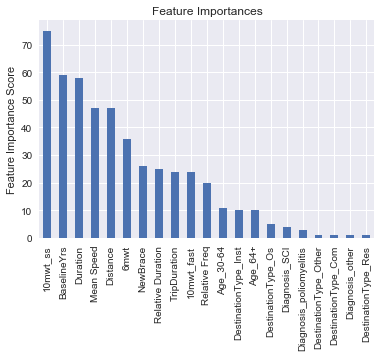

In [38]:
#Choose all predictors except target & IDcols
target = 'Wear Frac'
predictors = [x for x in FeaturesNum.columns if x not in target]

xgbclf = XGBClassifier(learning_rate=0.1,n_estimators=200,max_depth=3,min_child_weight=1,gamma=0,subsample=1,
                       colsample_bytree=0.8, objective='binary:logistic',scale_pos_weight=1,seed=20)

feat_imp=modelfit(xgbclf,X_train,predictors,target)

**How the importance is calculated: **
either “weight”, “gain”, or “cover”. 
* “weight” (default) is the number of times a feature appears in a tree
* “gain” is the average gain of splits which use the feature 
* “cover” is the average coverage of splits which use the feature - where coverage is defined as the number of samples affected by the split

In [41]:
#predict on test set
ytest_pred=xgbclf.predict(X_test[predictors])
ytest_predprob = xgbclf.predict_proba(X_test[predictors])[:,1]
print('Acc (test) = %.3f'%metrics.accuracy_score(y_test,ytest_pred))
print('AUC (test) = %.3f'%metrics.roc_auc_score(y_test,ytest_predprob))
sens = sum((y_test==1) & (y_test==ytest_pred))/(sum(y_test==1))
spec = sum((y_test==0) & (y_test==ytest_pred))/(sum(y_test==0))
print('Sens = %.2f, Spec = %.2f'%(sens,spec))

Acc (test) = 0.912
AUC (test) = 0.962
Sens = 0.97, Spec = 0.71


Accuracy (Train) : 0.7627
AUC Score (Train): 0.839772
Optimal N trees = 3


Mean Speed      6
TripDuration    3
NewBrace        3
dtype: int64

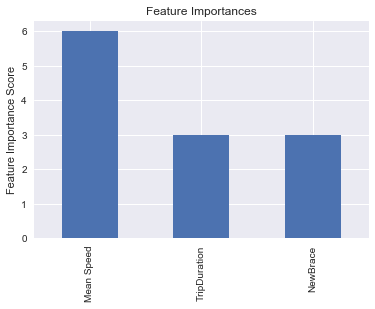

In [267]:
#Choose all predictors except target & IDcols
target = 'Wear Frac'
predictors = [x for x in FeaturesNum.columns if x not in target]

xgbclf = XGBClassifier(learning_rate=0.1,n_estimators=200,max_depth=3,min_child_weight=1,gamma=0,subsample=1,
                       colsample_bytree=0.8, objective='binary:logistic',scale_pos_weight=1,seed=20)

modelfit(xgbclf,X_train,predictors,target)

## LOSO CV

In [140]:
from sklearn.model_selection import LeaveOneGroupOut

groups = SubjID.as_matrix()
logo = LeaveOneGroupOut()
logo.get_n_splits(FeaturesNum[predictors],FeaturesNum[target],groups)

14

In [76]:
# xgbclf = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,
#                        colsample_bytree=0.8, objective='binary:logistic',scale_pos_weight=1,seed=20)

In [220]:
def LOSOCV(FeaturesNum,predictors,target,groups,Verbose=True):
    
    F1_score_all = []; AUC_all = []; fimp_all = []; 
    fgain_all=[]; #other types of feature importance scores

    for train_idx,test_idx in logo.split(FeaturesNum[predictors],FeaturesNum[target],groups):

        #training data
        xgbclf = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,
                       colsample_bytree=0.8, objective='binary:logistic',scale_pos_weight=1,seed=22)
        
        dtrain = xgb.DMatrix(FeaturesNum[predictors].values[train_idx],label=FeaturesNum[target].values[train_idx])

        #use CV to find optimal number of trees
#         xgb_param=xgbclf.get_xgb_params()

#         cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgbclf.get_params()['n_estimators'], nfold=5,  
#                           metrics='auc', early_stopping_rounds=50, stratified=False, verbose_eval=False)

#         xgbclf.set_params(n_estimators=cvresult.shape[0])

        #Fit the algorithm on the data
        xgbclf.fit(FeaturesNum[predictors].iloc[train_idx,:], FeaturesNum[target].iloc[train_idx],eval_metric='auc')

        #Predict on training set:
        dtrain_predictions = xgbclf.predict(FeaturesNum[predictors].iloc[train_idx,:])
        dtrain_predprob = xgbclf.predict_proba(FeaturesNum[predictors].iloc[train_idx,:])[:,1]
        fimp_all.append(xgbclf.get_booster().get_fscore())   #store fimp for each round of CV (subject-wise)
        fgain_all.append(xgbclf.get_booster().get_score(importance_type='gain'))

        #Predict on test set:
        dtest_predictions = xgbclf.predict(FeaturesNum[predictors].iloc[test_idx,:])
        dtest_predprob = xgbclf.predict_proba(FeaturesNum[predictors].iloc[test_idx,:])[:,1]
        
        #metrics on testset
        F1_score_all.append(metrics.f1_score(FeaturesNum['Wear Frac'].values[test_idx], dtest_predictions))
        try:
            AUC_all.append(metrics.roc_auc_score(FeaturesNum['Wear Frac'].values[test_idx], dtest_predprob))
        except(ValueError):
            continue

        #display
        if Verbose:
            
            print("Accuracy (Train) : %.4g" % metrics.accuracy_score(FeaturesNum['Wear Frac'].values[train_idx], dtrain_predictions))
            print("AUC Score (Train): %f" % metrics.roc_auc_score(FeaturesNum['Wear Frac'].values[train_idx], dtrain_predprob))
            print('F1-score (Train): %.3f' % metrics.f1_score(FeaturesNum['Wear Frac'].values[train_idx], dtrain_predictions))
            print('Optimal N trees = %d'%xgbclf.get_booster().best_ntree_limit)

            print("Accuracy (Test) : %.4g" % metrics.accuracy_score(FeaturesNum['Wear Frac'].values[test_idx], dtest_predictions))
            try:
                print("AUC Score (Test): %f" % metrics.roc_auc_score(FeaturesNum['Wear Frac'].values[test_idx], dtest_predprob))
                print('F1-score (Test): %.3f' % metrics.f1_score(FeaturesNum['Wear Frac'].values[test_idx], dtest_predictions))
            except(ValueError):
                print('Only one class present in y_true. ROC AUC score is not defined.')
            
            print('Npos/Nneg (train) = %.2f, Npos/Nneg (test) = %.2f' % (
                  sum(FeaturesNum[target].values[train_idx] == 1)/sum(FeaturesNum[target].values[train_idx] == 0),
                  sum(FeaturesNum[target].values[test_idx] == 1)/sum(FeaturesNum[target].values[test_idx] == 0)))
            print('\n')
        
    #mean F1score across subjects
    print('Mean F1-score = %.3f +/- %.3f' % (np.mean(F1_score_all), 1.96*np.std(F1_score_all)/np.sqrt(len(F1_score_all))) )
    print('Mean AUC = %.3f +/- %.3f' % (np.mean(AUC_all), 1.96*np.std(AUC_all)/np.sqrt(len(AUC_all))) )
    return xgbclf,fimp_all,fgain_all,fcover_all

In [221]:
xgbclf,fimp_all,fgain_all=LOSOCV(FeaturesNum,predictors,target,groups,Verbose=False)

Mean F1-score = 0.834 +/- 0.101
Mean AUC = 0.659 +/- 0.116


In [226]:
fimp=pd.DataFrame(fimp_all)
fgain=pd.DataFrame(fgain_all)
# ax=fimp.hist(figsize=(18,12))

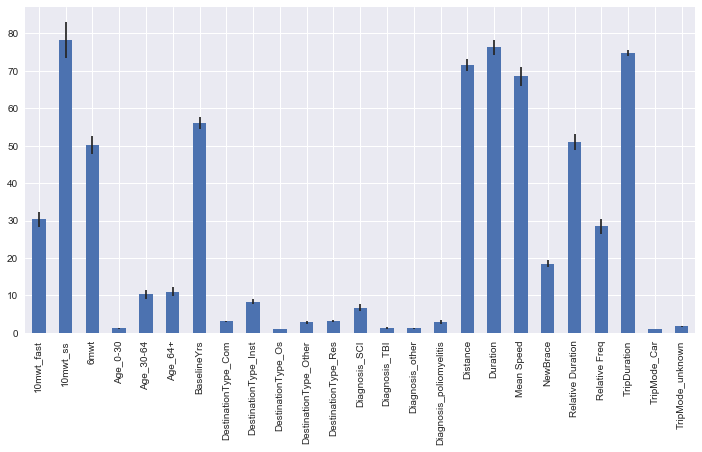

In [227]:
m,s=(fimp.mean(),fimp.std()) #how many times feature is used in trees
m.plot(kind='bar',yerr=s/np.sqrt(len(fimp)),figsize=(12,6))

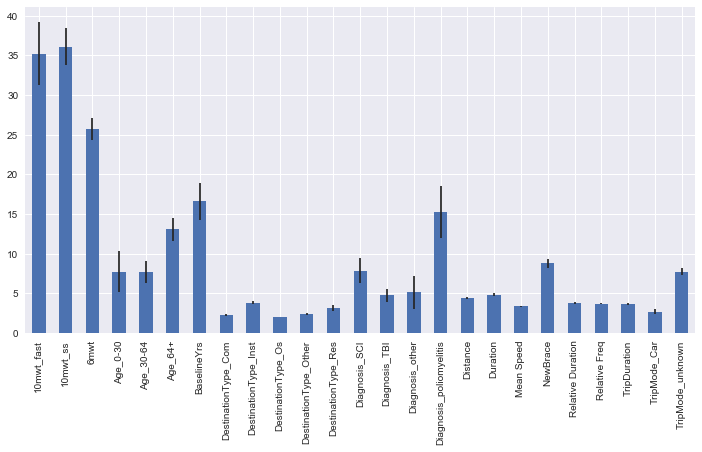

In [228]:
m,s=(fgain.mean(),fgain.std()) #improvement in accuracy after splitting on the feature
m.plot(kind='bar',yerr=s/np.sqrt(len(fgain)),figsize=(12,6))

## Train models with different number of subjects (LPGO) and check feature importance stats

In [15]:
print(sum(FeaturesNum[target]==0)/sum(FeaturesNum[target]==1)) #the class ratio (0 to 1)

0.316717019134


In [16]:
#the number of samples in each class per subj
for s in SubjID.unique():
    inds = np.where(SubjID==s)[0]
    X_train = FeaturesNum[predictors].iloc[inds,:]
    X_train[target]=FeaturesNum[target].iloc[inds]
    print(sum(X_train[target]==0),sum(X_train[target]==1))

156 56
14 399
20 83
23 62
1 41
3 663
324 124
0 123
3 51
11 145
16 94
5 10
2 68
51 67


In [17]:
from sklearn.model_selection import LeavePGroupsOut
groups = SubjID.as_matrix()

In [154]:
lpgo = LeavePGroupsOut(n_groups=11)
lpgo.get_n_splits(FeaturesNum[predictors],FeaturesNum[target],groups)

364

In [19]:
def LPSOCV(FeaturesNum,predictors,target,groups,ng,seed=22,Verbose=False):
    
    AUC_all = []; F1_score_all = []
    fimp_all = [];  fgain_all=[]; #feature importance scores

    lpgo = LeavePGroupsOut(n_groups=ng)
    lpgo.get_n_splits(FeaturesNum[predictors],FeaturesNum[target],groups)
    iteration = 0
    
    for train_idx,test_idx in lpgo.split(FeaturesNum[predictors],FeaturesNum[target],groups):
        iteration+=1

        #training data
        xgbclf = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,
                       colsample_bytree=0.8, objective='binary:logistic',scale_pos_weight=1,seed=seed)
        
        dtrain = xgb.DMatrix(FeaturesNum[predictors].values[train_idx],label=FeaturesNum[target].values[train_idx])
        
        #Fit the algorithm on the data
        xgbclf.fit(FeaturesNum[predictors].iloc[train_idx,:], FeaturesNum[target].iloc[train_idx],eval_metric='auc')

        #Predict on training set:
        dtrain_predictions = xgbclf.predict(FeaturesNum[predictors].iloc[train_idx,:])
        dtrain_predprob = xgbclf.predict_proba(FeaturesNum[predictors].iloc[train_idx,:])[:,1]
        fimp_all.append(xgbclf.get_booster().get_fscore())   #store fimp for each round of CV (subject-wise)
        fgain_all.append(xgbclf.get_booster().get_score(importance_type='gain'))
        #Predict on test set:
        dtest_predictions = xgbclf.predict(FeaturesNum[predictors].iloc[test_idx,:])
        dtest_predprob = xgbclf.predict_proba(FeaturesNum[predictors].iloc[test_idx,:])[:,1]
    
        #metrics on testset
        F1_score_all.append(metrics.f1_score(FeaturesNum['Wear Frac'].values[test_idx], dtest_predictions))
        if iteration%100==0:
            print('run_group=%d, F1(test) = %.3f'%(iteration,metrics.f1_score(FeaturesNum['Wear Frac'].values[test_idx], dtest_predictions)))
            print('N train datapoints = %d'%len(FeaturesNum[predictors].values[train_idx]))
#         try:
#             AUC_all.append(metrics.roc_auc_score(FeaturesNum['Wear Frac'].values[test_idx], dtest_predprob))
#         except(ValueError):
#             continue
                
    return xgbclf,fimp_all,fgain_all,F1_score_all

## Results using numerical features

run_group=100, F1(test) = 0.778
N train datapoints = 256
run_group=200, F1(test) = 0.700
N train datapoints = 407
run_group=300, F1(test) = 0.856
N train datapoints = 230
run_group=100, F1(test) = 0.782
N train datapoints = 1436
run_group=200, F1(test) = 0.865
N train datapoints = 736
run_group=300, F1(test) = 0.811
N train datapoints = 763
run_group=400, F1(test) = 0.809
N train datapoints = 433
run_group=500, F1(test) = 0.846
N train datapoints = 465
run_group=600, F1(test) = 0.842
N train datapoints = 405
run_group=700, F1(test) = 0.700
N train datapoints = 1397
run_group=800, F1(test) = 0.901
N train datapoints = 770
run_group=900, F1(test) = 0.932
N train datapoints = 1230
run_group=1000, F1(test) = 0.877
N train datapoints = 1444
run_group=1100, F1(test) = 0.837
N train datapoints = 698
run_group=1200, F1(test) = 0.920
N train datapoints = 1029
run_group=1300, F1(test) = 0.787
N train datapoints = 1052
run_group=1400, F1(test) = 0.727
N train datapoints = 1512
run_group=1500, F1(

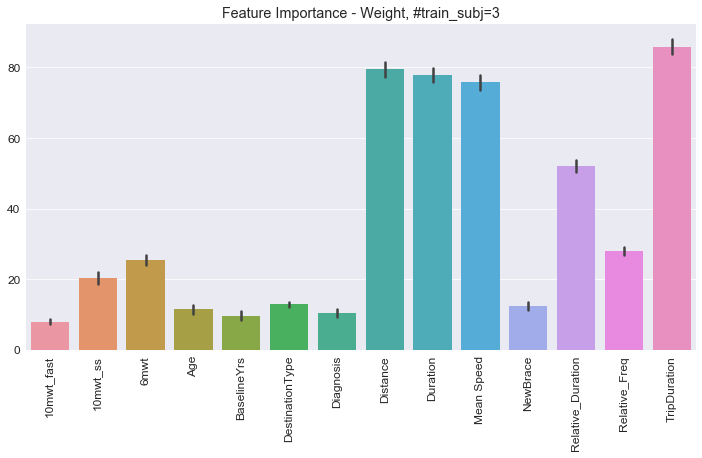

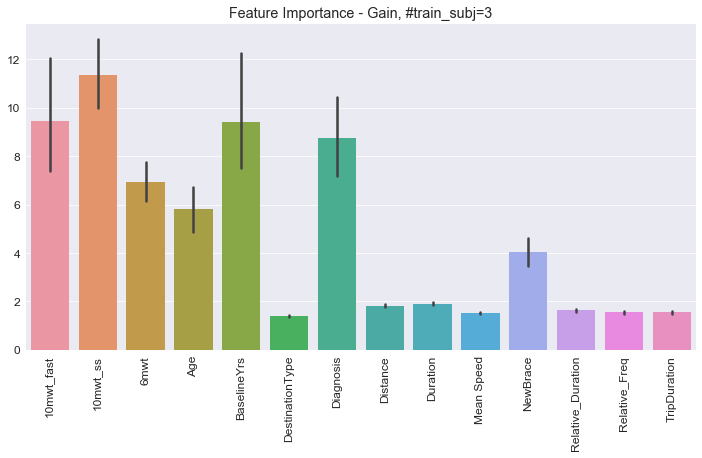

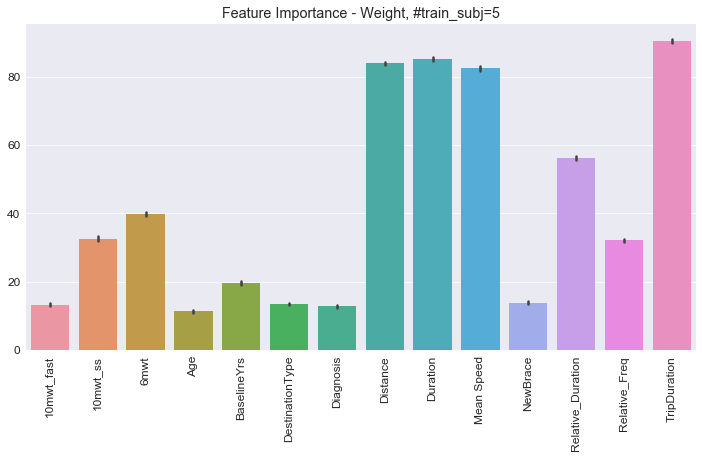

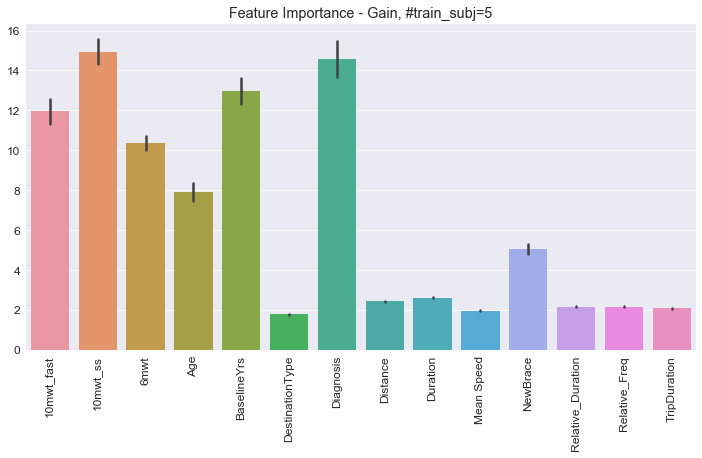

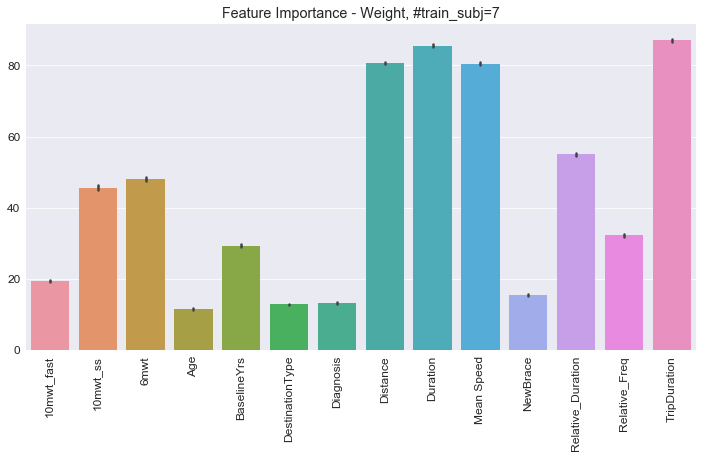

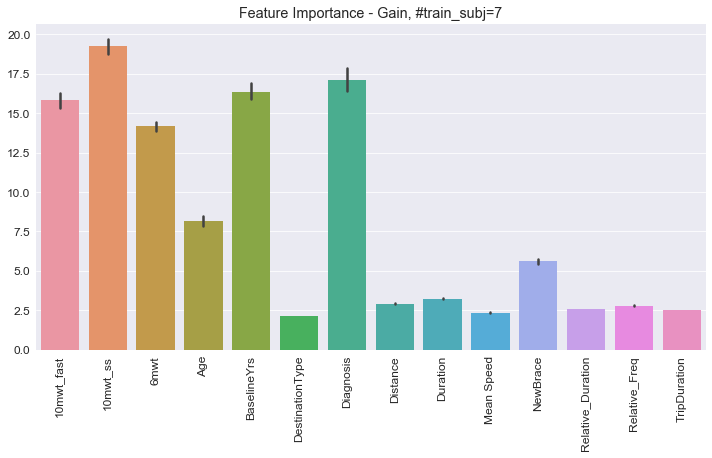

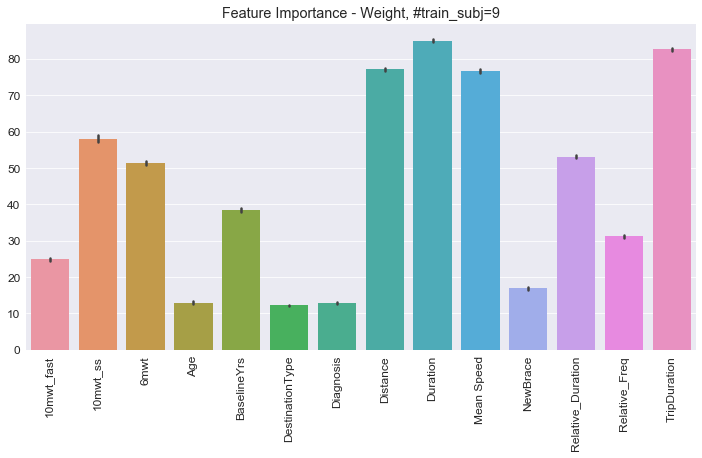

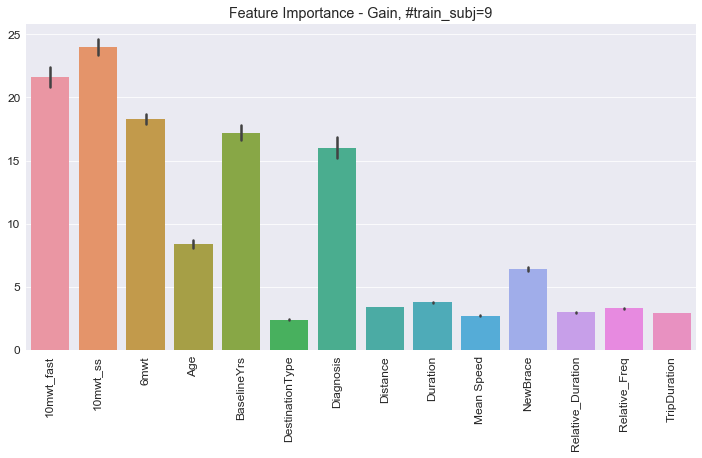

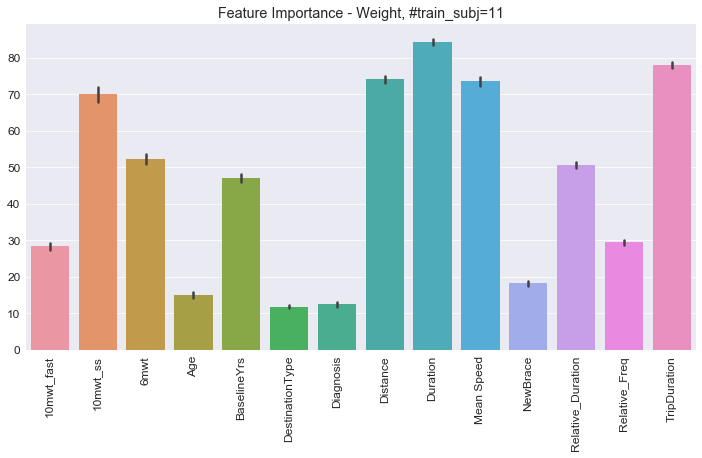

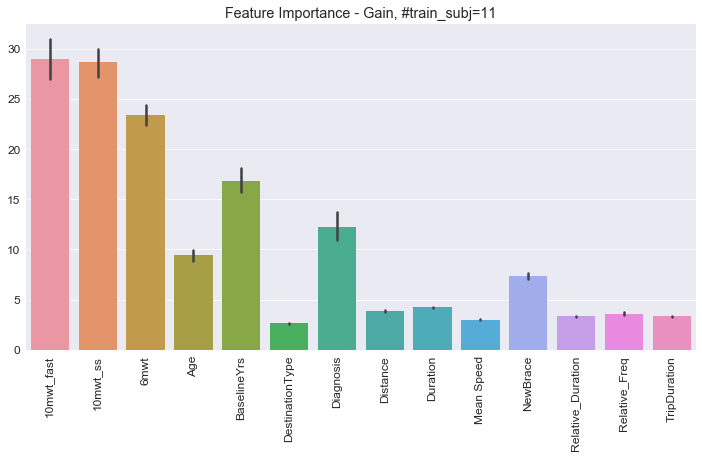

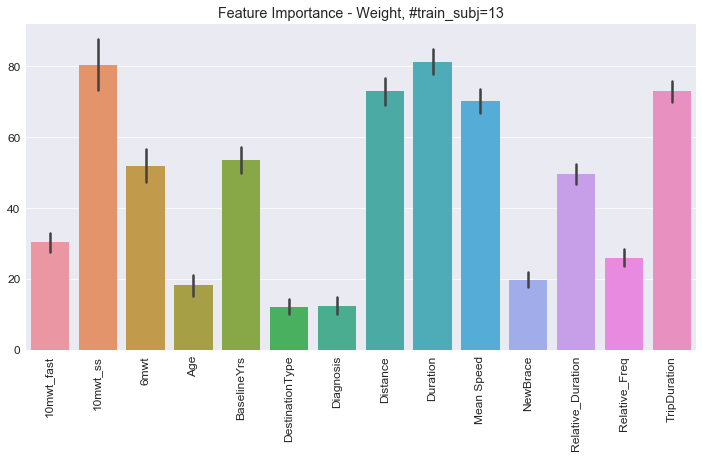

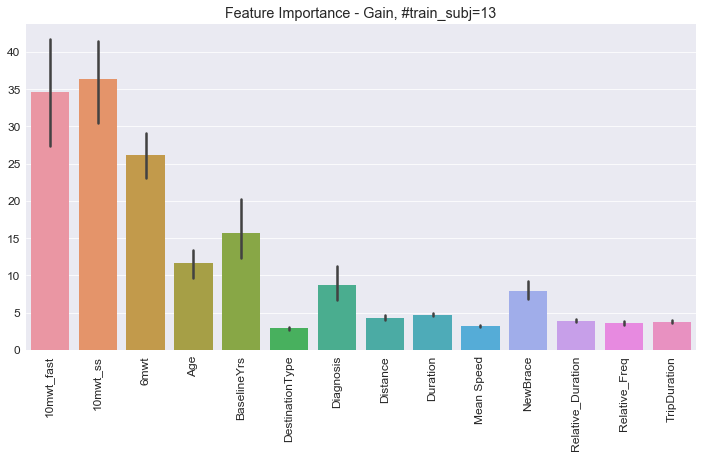

In [20]:
ntrainsub = [3,5,7,9,11,13]
f1_subj=[]; fimp_subj=[]; fgain_subj=[] #store values across runs and subjects
t1 = time.time()
for ng in ntrainsub:
    nlo = 14-ng
    xgbclf,fimp_all,fgain_all,f1=LPSOCV(FeaturesNum,predictors,target,groups,nlo)
    sns.set_context('paper',font_scale=1.5)
    fimp=pd.DataFrame(fimp_all)
    fgain=pd.DataFrame(fgain_all)
    plt.figure(figsize=(12,6))
    ax=sns.barplot(data=fimp)
    ax=plt.xticks(rotation=90)
    plt.title('Feature Importance - Weight, #train_subj='+str(ng))
    plt.savefig('./img/FI_weight_'+str(ng)+'.jpg')

    plt.figure(figsize=(12,6))
    ax=sns.barplot(data=fgain)
    ax=plt.xticks(rotation=90)
    plt.title('Feature Importance - Gain, #train_subj='+str(ng))
    plt.savefig('./img/FI_gain_'+str(ng)+'.jpg')

    f1_subj.append(f1) #distribution of f1 scores across different runs and # of subejcts
    fimp_subj.append(fimp_all)
    fgain_subj.append(fgain_all)

t2 = time.time()
eltime=t2-t1
np.

## Results using one-hot encoded features

run_group=100, F1(test) = 0.789
run_group=200, F1(test) = 0.797
run_group=300, F1(test) = 0.803
run_group=100, F1(test) = 0.752
run_group=200, F1(test) = 0.763
run_group=300, F1(test) = 0.771
run_group=400, F1(test) = 0.779
run_group=500, F1(test) = 0.782
run_group=600, F1(test) = 0.785
run_group=700, F1(test) = 0.786
run_group=800, F1(test) = 0.790
run_group=900, F1(test) = 0.791
run_group=1000, F1(test) = 0.796
run_group=1100, F1(test) = 0.804
run_group=1200, F1(test) = 0.810
run_group=1300, F1(test) = 0.814
run_group=1400, F1(test) = 0.812
run_group=1500, F1(test) = 0.811
run_group=1600, F1(test) = 0.811
run_group=1700, F1(test) = 0.810
run_group=1800, F1(test) = 0.810
run_group=1900, F1(test) = 0.812
run_group=2000, F1(test) = 0.815
run_group=100, F1(test) = 0.735
run_group=200, F1(test) = 0.744
run_group=300, F1(test) = 0.749
run_group=400, F1(test) = 0.753
run_group=500, F1(test) = 0.756
run_group=600, F1(test) = 0.756
run_group=700, F1(test) = 0.759
run_group=800, F1(test) = 0.7

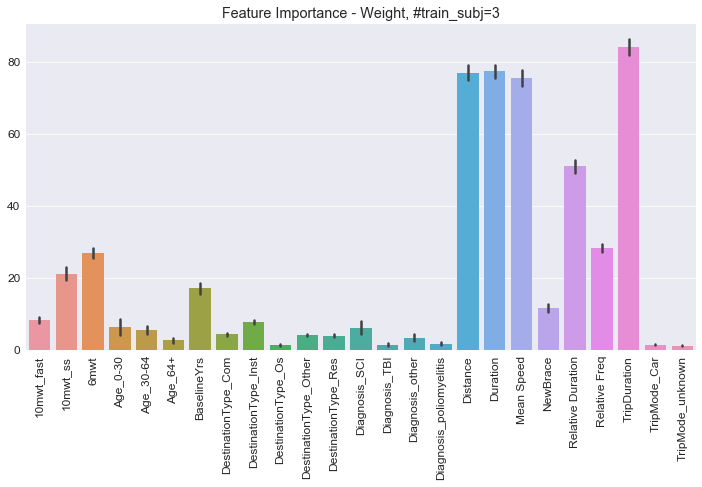

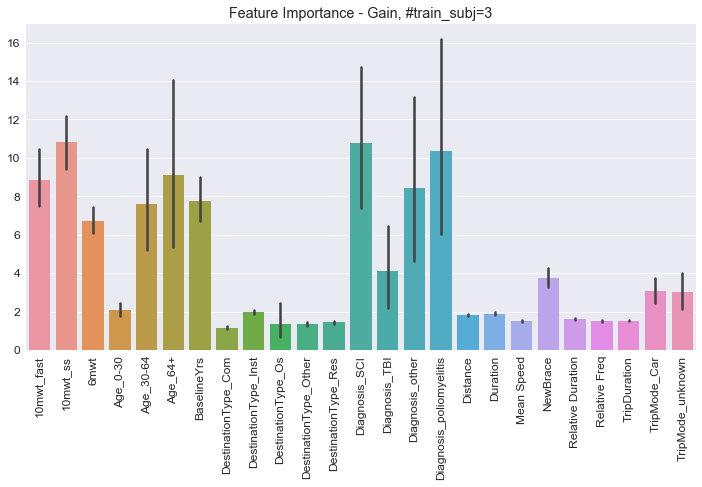

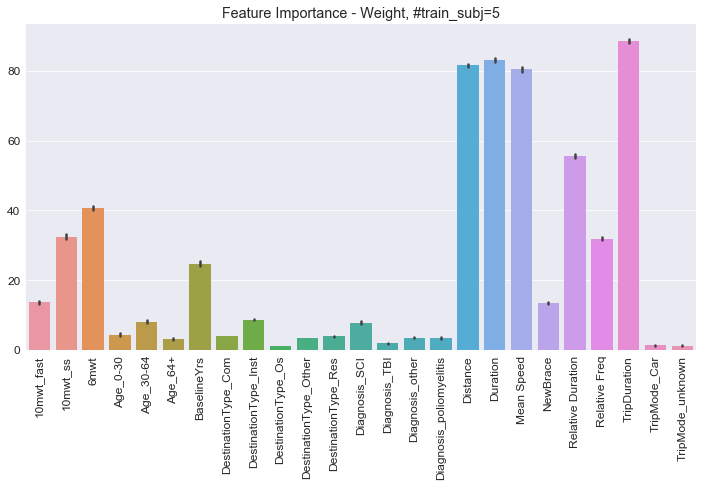

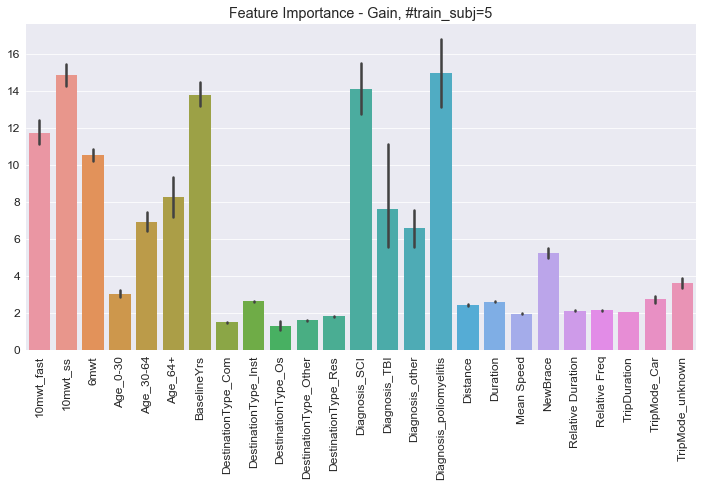

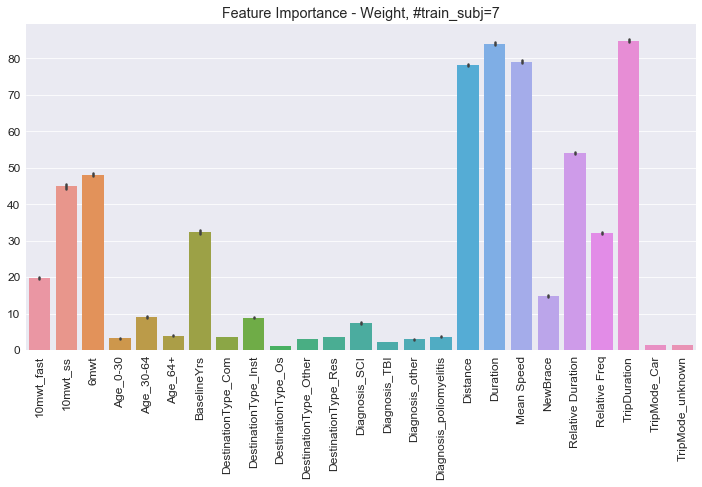

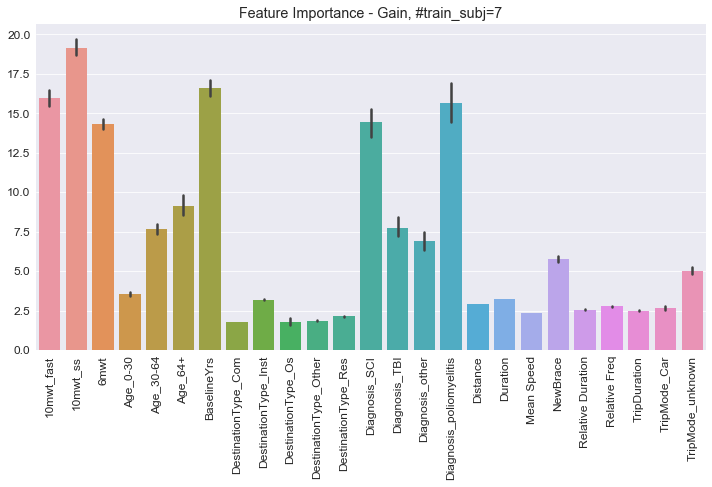

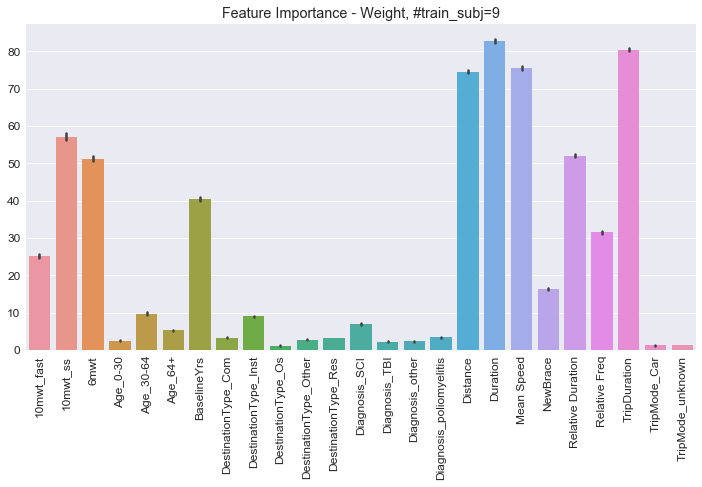

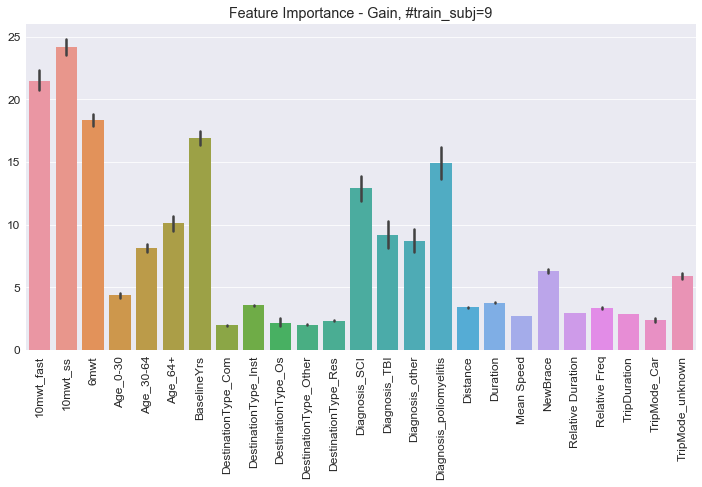

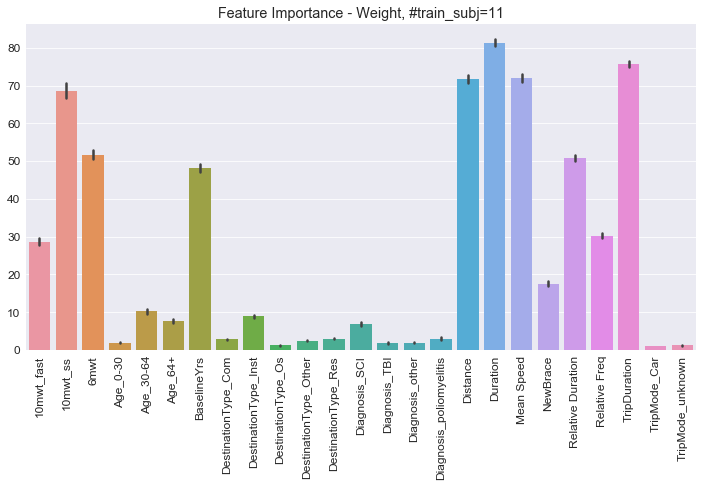

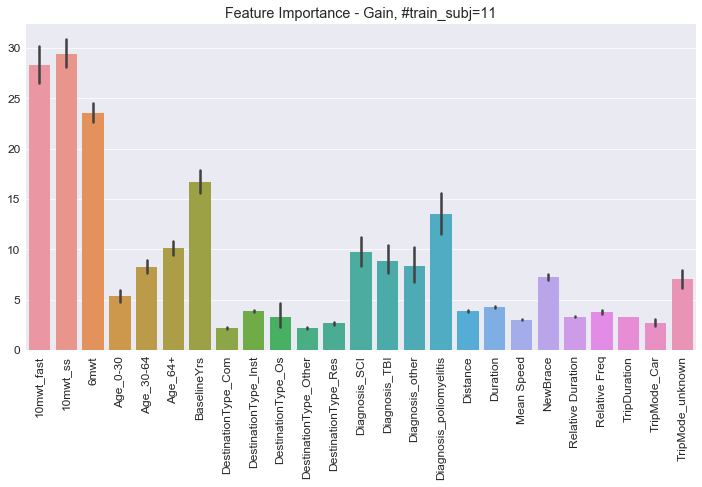

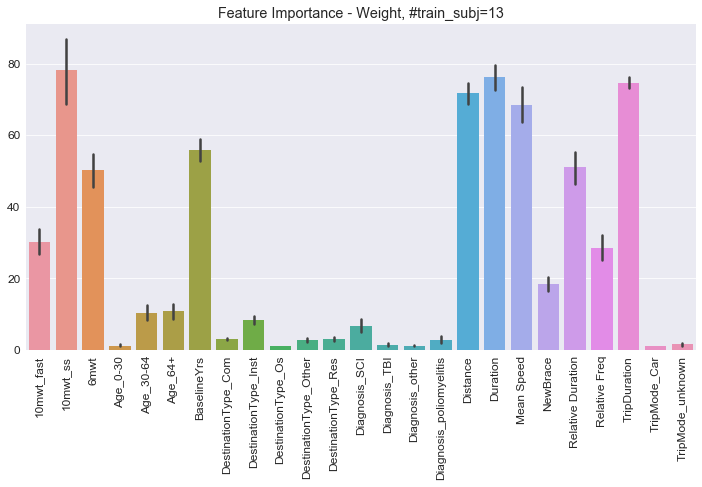

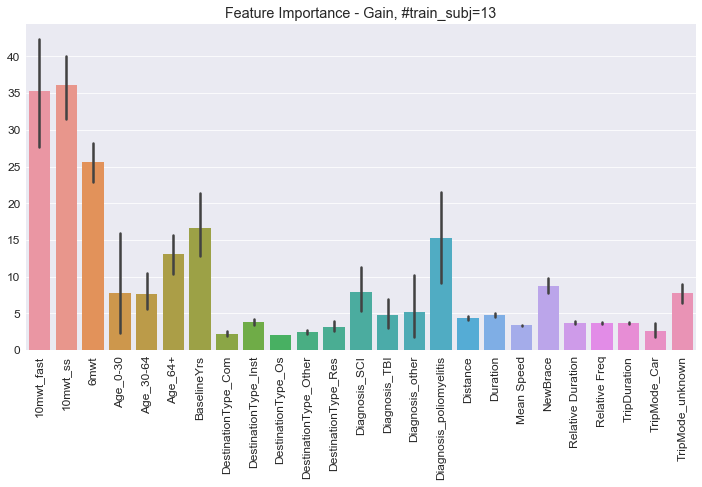

In [60]:
ntrainsub = [3,5,7,9,11,13]
for ng in ntrainsub:
    nlo = 14-ng
    xgbclf,fimp_all,fgain_all,_=LPSOCV(FeaturesNum,predictors,target,groups,nlo)
    sns.set_context('paper',font_scale=1.5)
    fimp=pd.DataFrame(fimp_all)
    fgain=pd.DataFrame(fgain_all)
    plt.figure(figsize=(12,6))
    ax=sns.barplot(data=fimp)
    ax=plt.xticks(rotation=90)
    plt.title('Feature Importance - Weight, #train_subj='+str(ng))
    plt.figure(figsize=(12,6))
    ax=sns.barplot(data=fgain)
    ax=plt.xticks(rotation=90)
    plt.title('Feature Importance - Gain, #train_subj='+str(ng))

### Plot Feature importance as a function of # of subjects

In [189]:
#unpack and select features that shows in half the trees
m = fimp.mean()
# m.values.sort()
# m=m[m > 50][:5]
m = m.sort_values(ascending=False)
top5 = m[:5]

## Top-5 Feature values for wear and non wear

In [190]:
top5

Duration        81.142857
10mwt_ss        80.500000
Distance        73.071429
TripDuration    72.928571
Mean Speed      70.285714
dtype: float64

In [208]:
FeaturesNum.head()

,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,NewBrace,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast
0,0.0,1,6.302016,1.758333,0.230411,0.011921,0.014925,0.013607,1,2,3,60.0,231.93,0.69,0.85
1,0.0,0,5.095353,1.016389,0.591493,0.008218,0.014925,0.007865,1,2,3,60.0,231.93,0.69,0.85
2,0.0,0,5.172335,0.366111,1.607549,0.001505,0.029851,0.004252,1,2,3,60.0,231.93,0.69,0.85
3,0.0,0,2.871296,0.052778,4.483316,0.003704,0.044776,0.001827,1,2,3,60.0,231.93,0.69,0.85
4,0.0,0,2.870687,0.033333,7.098997,0.004514,0.044776,0.001827,1,2,3,60.0,231.93,0.69,0.85


In [262]:
top5f = FeaturesNum[top5.index].copy()
top5f.loc[top5f['Distance']>200,'Distance']=200

In [308]:
fnorm.head()

,Duration,10mwt_ss,Distance,TripDuration,Mean Speed,Wear Frac
0,0.073171,0.369048,0.031464,0.062247,0.004607,0.0
1,0.042247,0.369048,0.025430,0.042889,0.011827,0.0
2,0.015144,0.369048,0.025815,0.007804,0.032144,0.0
3,0.002084,0.369048,0.014309,0.019297,0.089648,0.0
4,0.001274,0.369048,0.014306,0.023532,0.141951,0.0


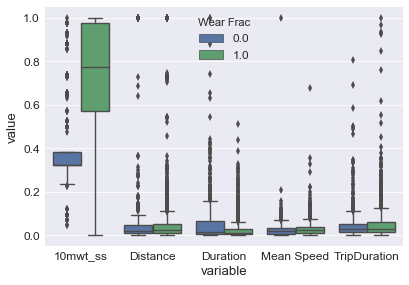

In [325]:
fnorm = top5f.copy() 
fnorm = fnorm.apply(lambda x: (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))  ) #rescale features between 0 and 1
fnorm[target] = FeaturesNum[target]
fnorm[target]=fnorm[target].astype('category')
fnorm=pd.melt(fnorm, id_vars=target, value_vars=set(fnorm.columns)-set([target]))
ax = sns.boxplot(data=fnorm,x='variable',y='value',hue=target)

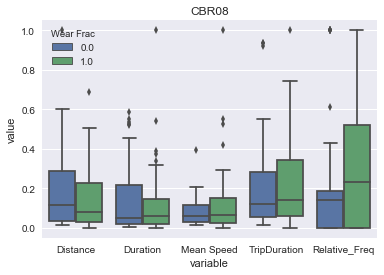

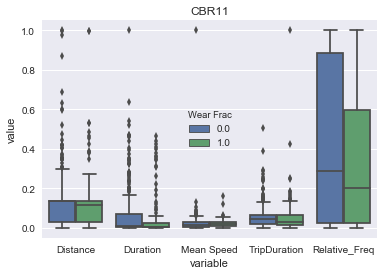

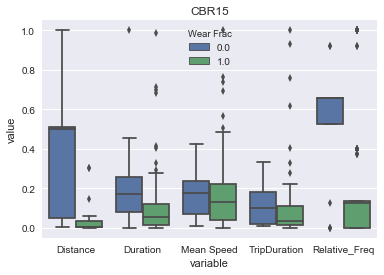

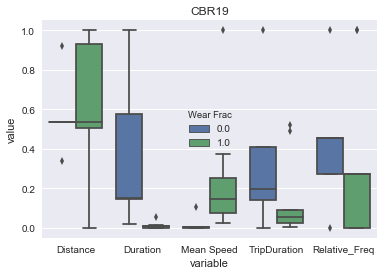

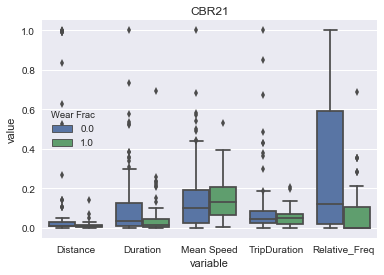

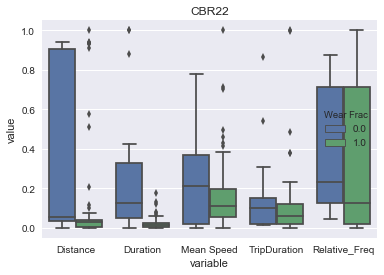

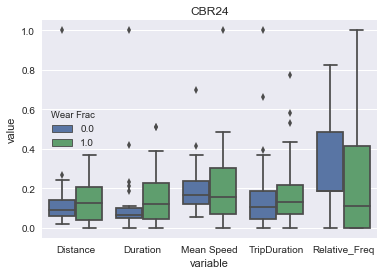

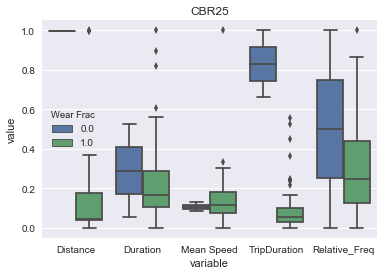

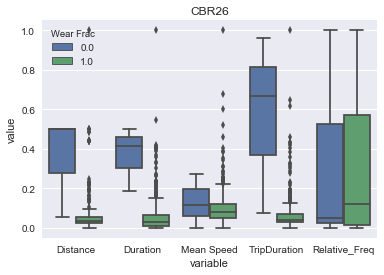

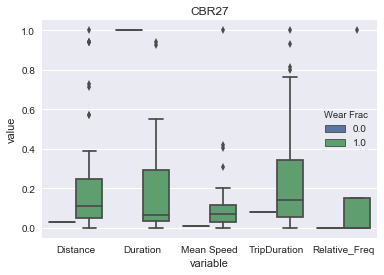

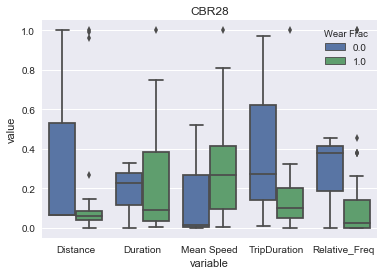

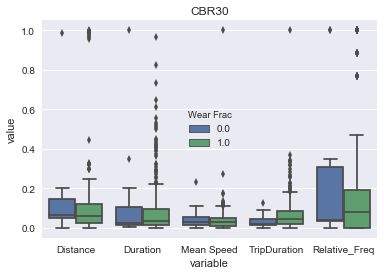

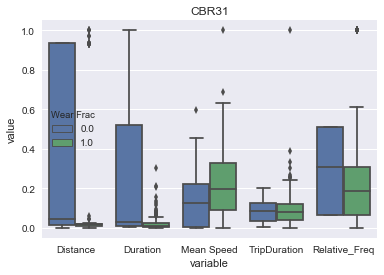

In [19]:
target='Wear Frac'
for s in np.sort(Features.SubjID.unique()):
    plt.figure()
    fnorm = Features.copy()
    fnorm=fnorm[fnorm.SubjID==s]
    fnorm[target]=fnorm[target].astype('category')
    if len(fnorm[target].unique()) < 2:
        continue
    fnorm=fnorm.drop(['DestinationType','Diagnosis','Age','SubjID'],axis=1)
    fnorm = fnorm.apply(lambda x: (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))  )
    fnorm=pd.melt(fnorm, id_vars='Wear Frac', value_vars=['Distance','Duration','Mean Speed','TripDuration','Relative_Freq'])
    ax = sns.boxplot(data=fnorm,x='variable',y='value',hue=target)
    ax=plt.title(str(s))

### Train a clf using xgb native interface and plot trees
more on plotting https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

In [28]:
#stratified split into train and test set
X_train,X_test,y_train,y_test = train_test_split(FeaturesNum[predictors],FeaturesNum[target],
                                                 test_size=0.33,random_state=32)
X_train[target]=y_train
X_test[target]=y_test

In [29]:
dtrain = xgb.DMatrix(X_train[predictors].values,label=X_train[target].values,feature_names=predictors)
dtest = xgb.DMatrix(X_test[predictors].values,label=X_test[target].values,feature_names=predictors)

In [30]:
xgbclf = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,
                       colsample_bytree=0.8, objective='binary:logistic',scale_pos_weight=1,seed=22)

xgb_param=xgbclf.get_xgb_params()
bst = xgb.train(xgb_param, dtrain, num_boost_round=30)


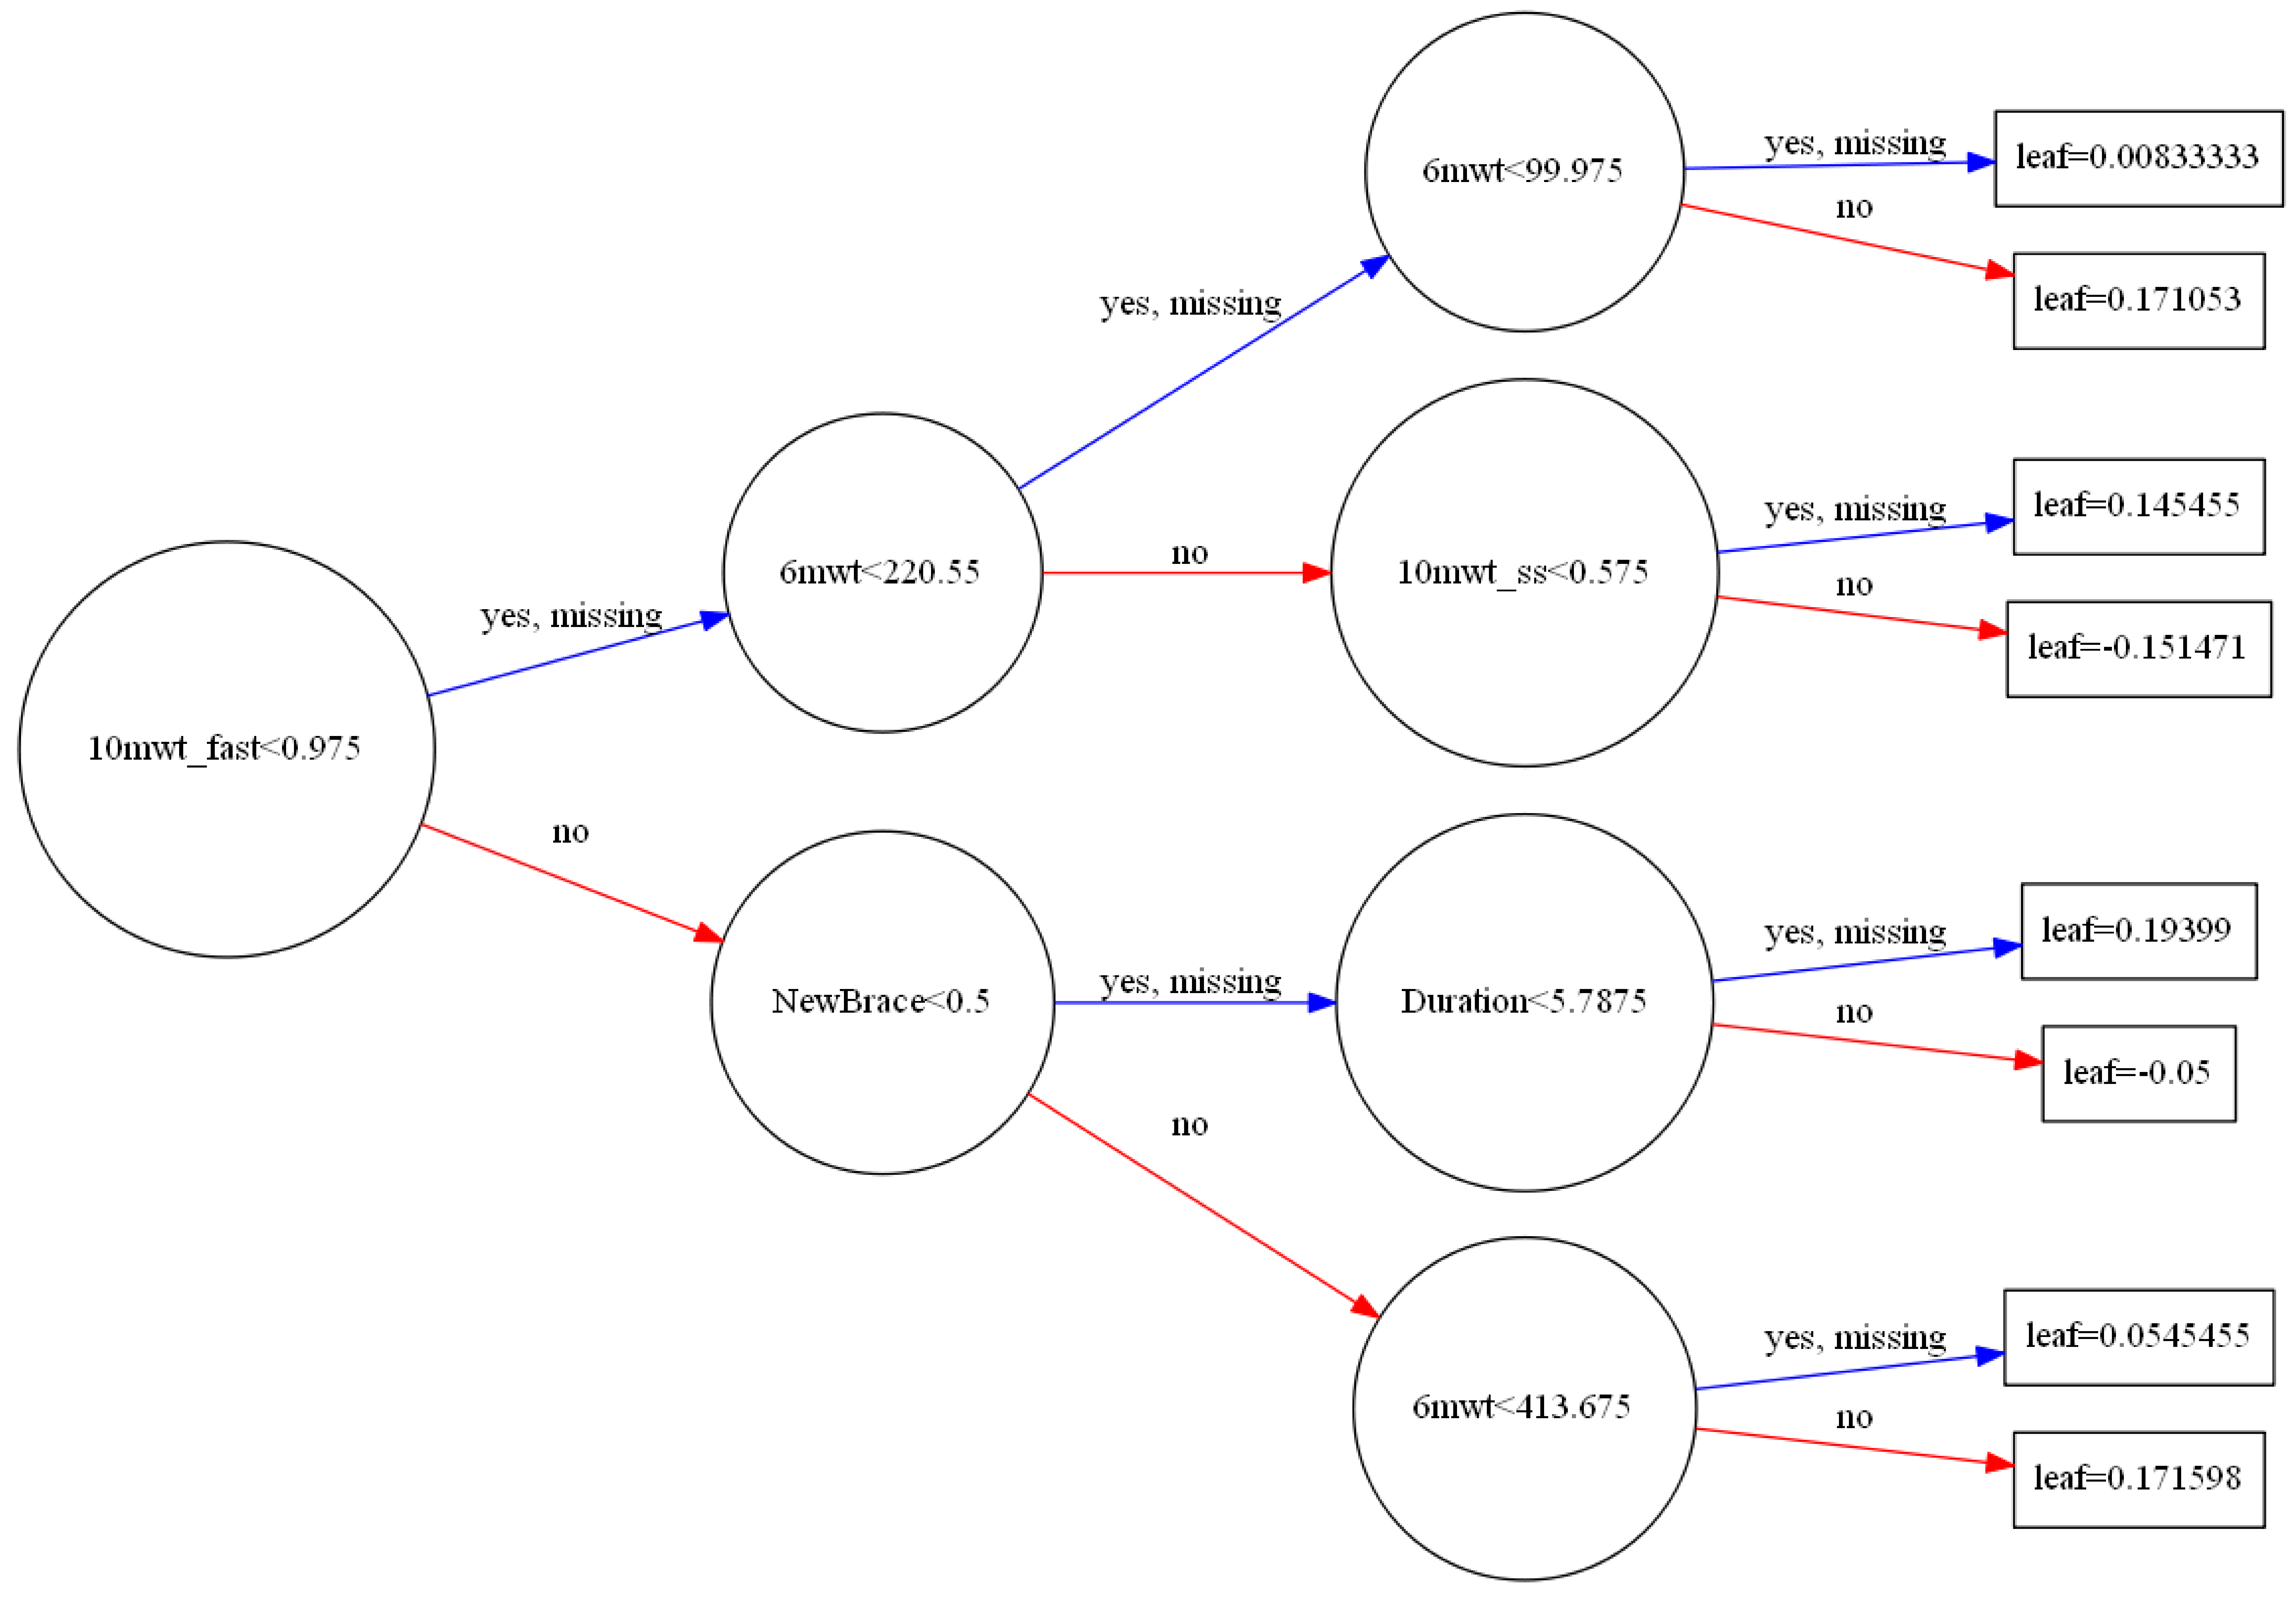

In [38]:
xgb.plot_tree(bst,num_trees=0,rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('img/tree0.png')

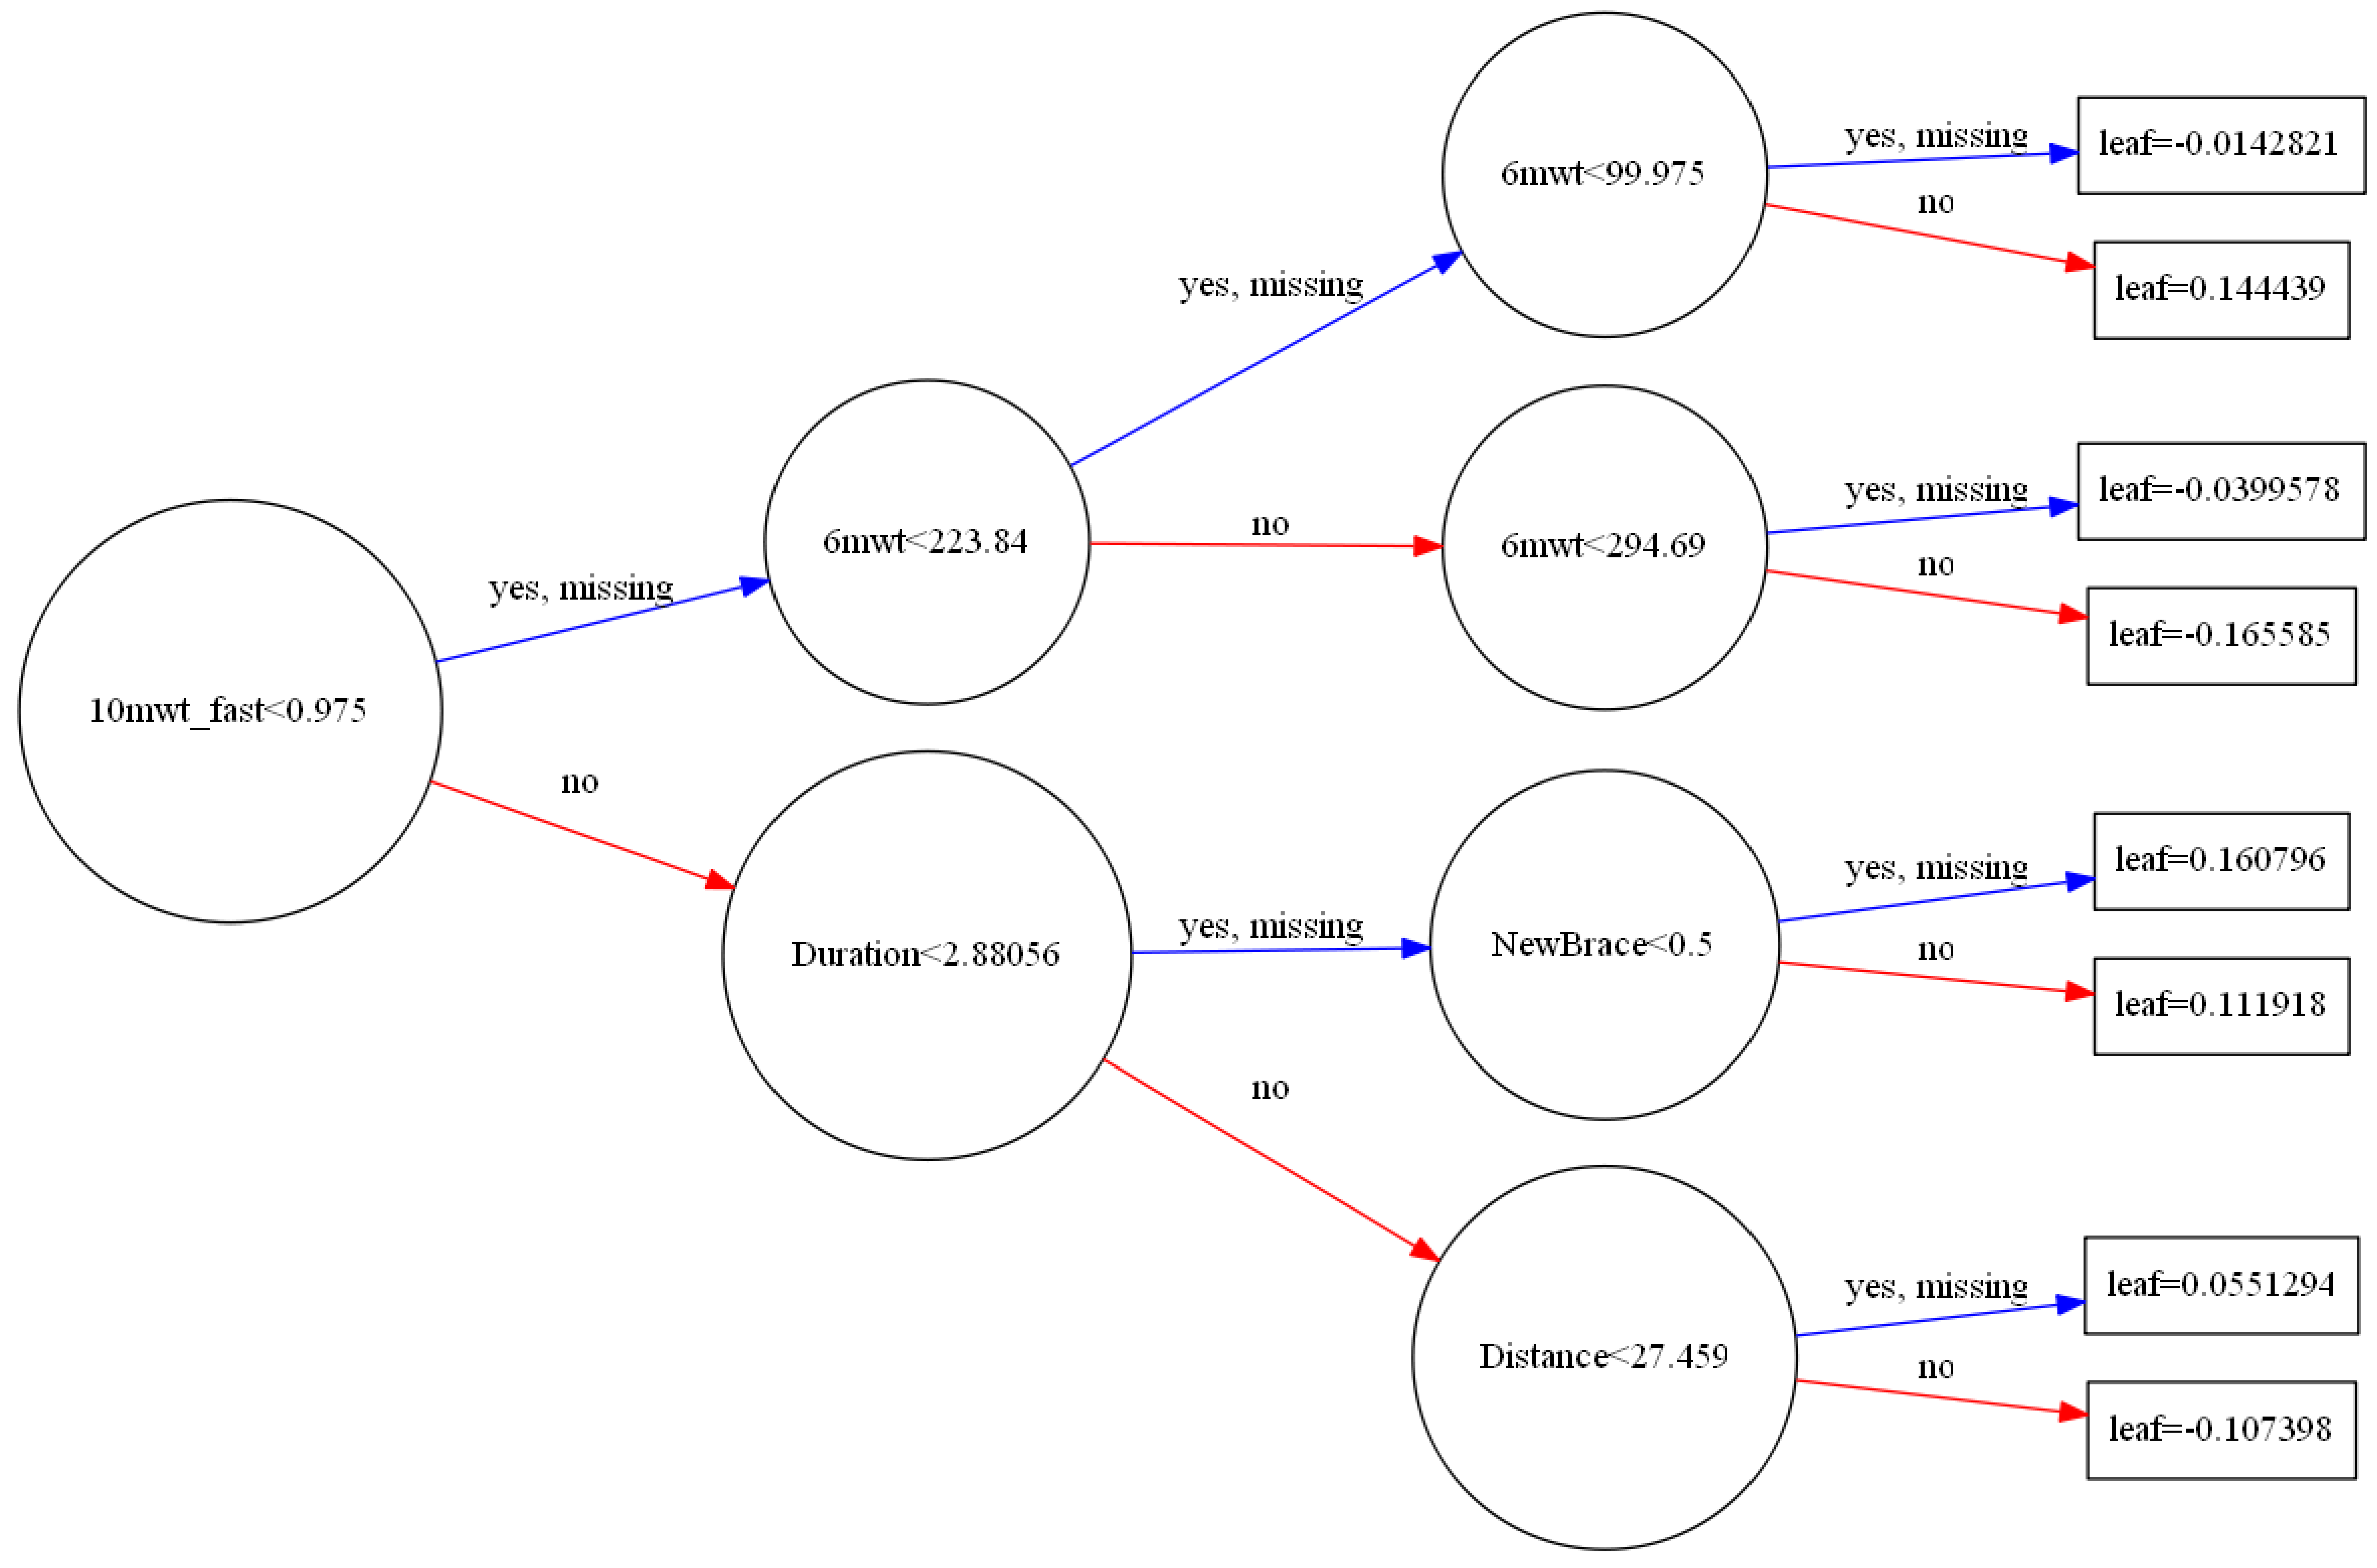

In [39]:
xgb.plot_tree(bst,num_trees=2,rankdir='LR')
# plt.savefig('img/tree.png')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('img/tree2.png')

### plot trees with LPGO

In [78]:
xgbclf,fimp_all,fgain_all,f1all=LPSOCV(FeaturesNum,predictors,target,groups,11,seed=11)


run_group=100, F1(test) = 0.747
N train datapoints = 256
run_group=200, F1(test) = 0.677
N train datapoints = 407
run_group=300, F1(test) = 0.859
N train datapoints = 230


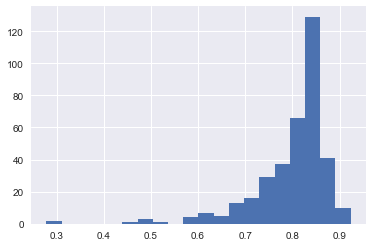

In [79]:
f1all=np.asarray(f1all)
ax=plt.hist(f1all,bins=20)

In [80]:
clf = xgbclf.get_booster()

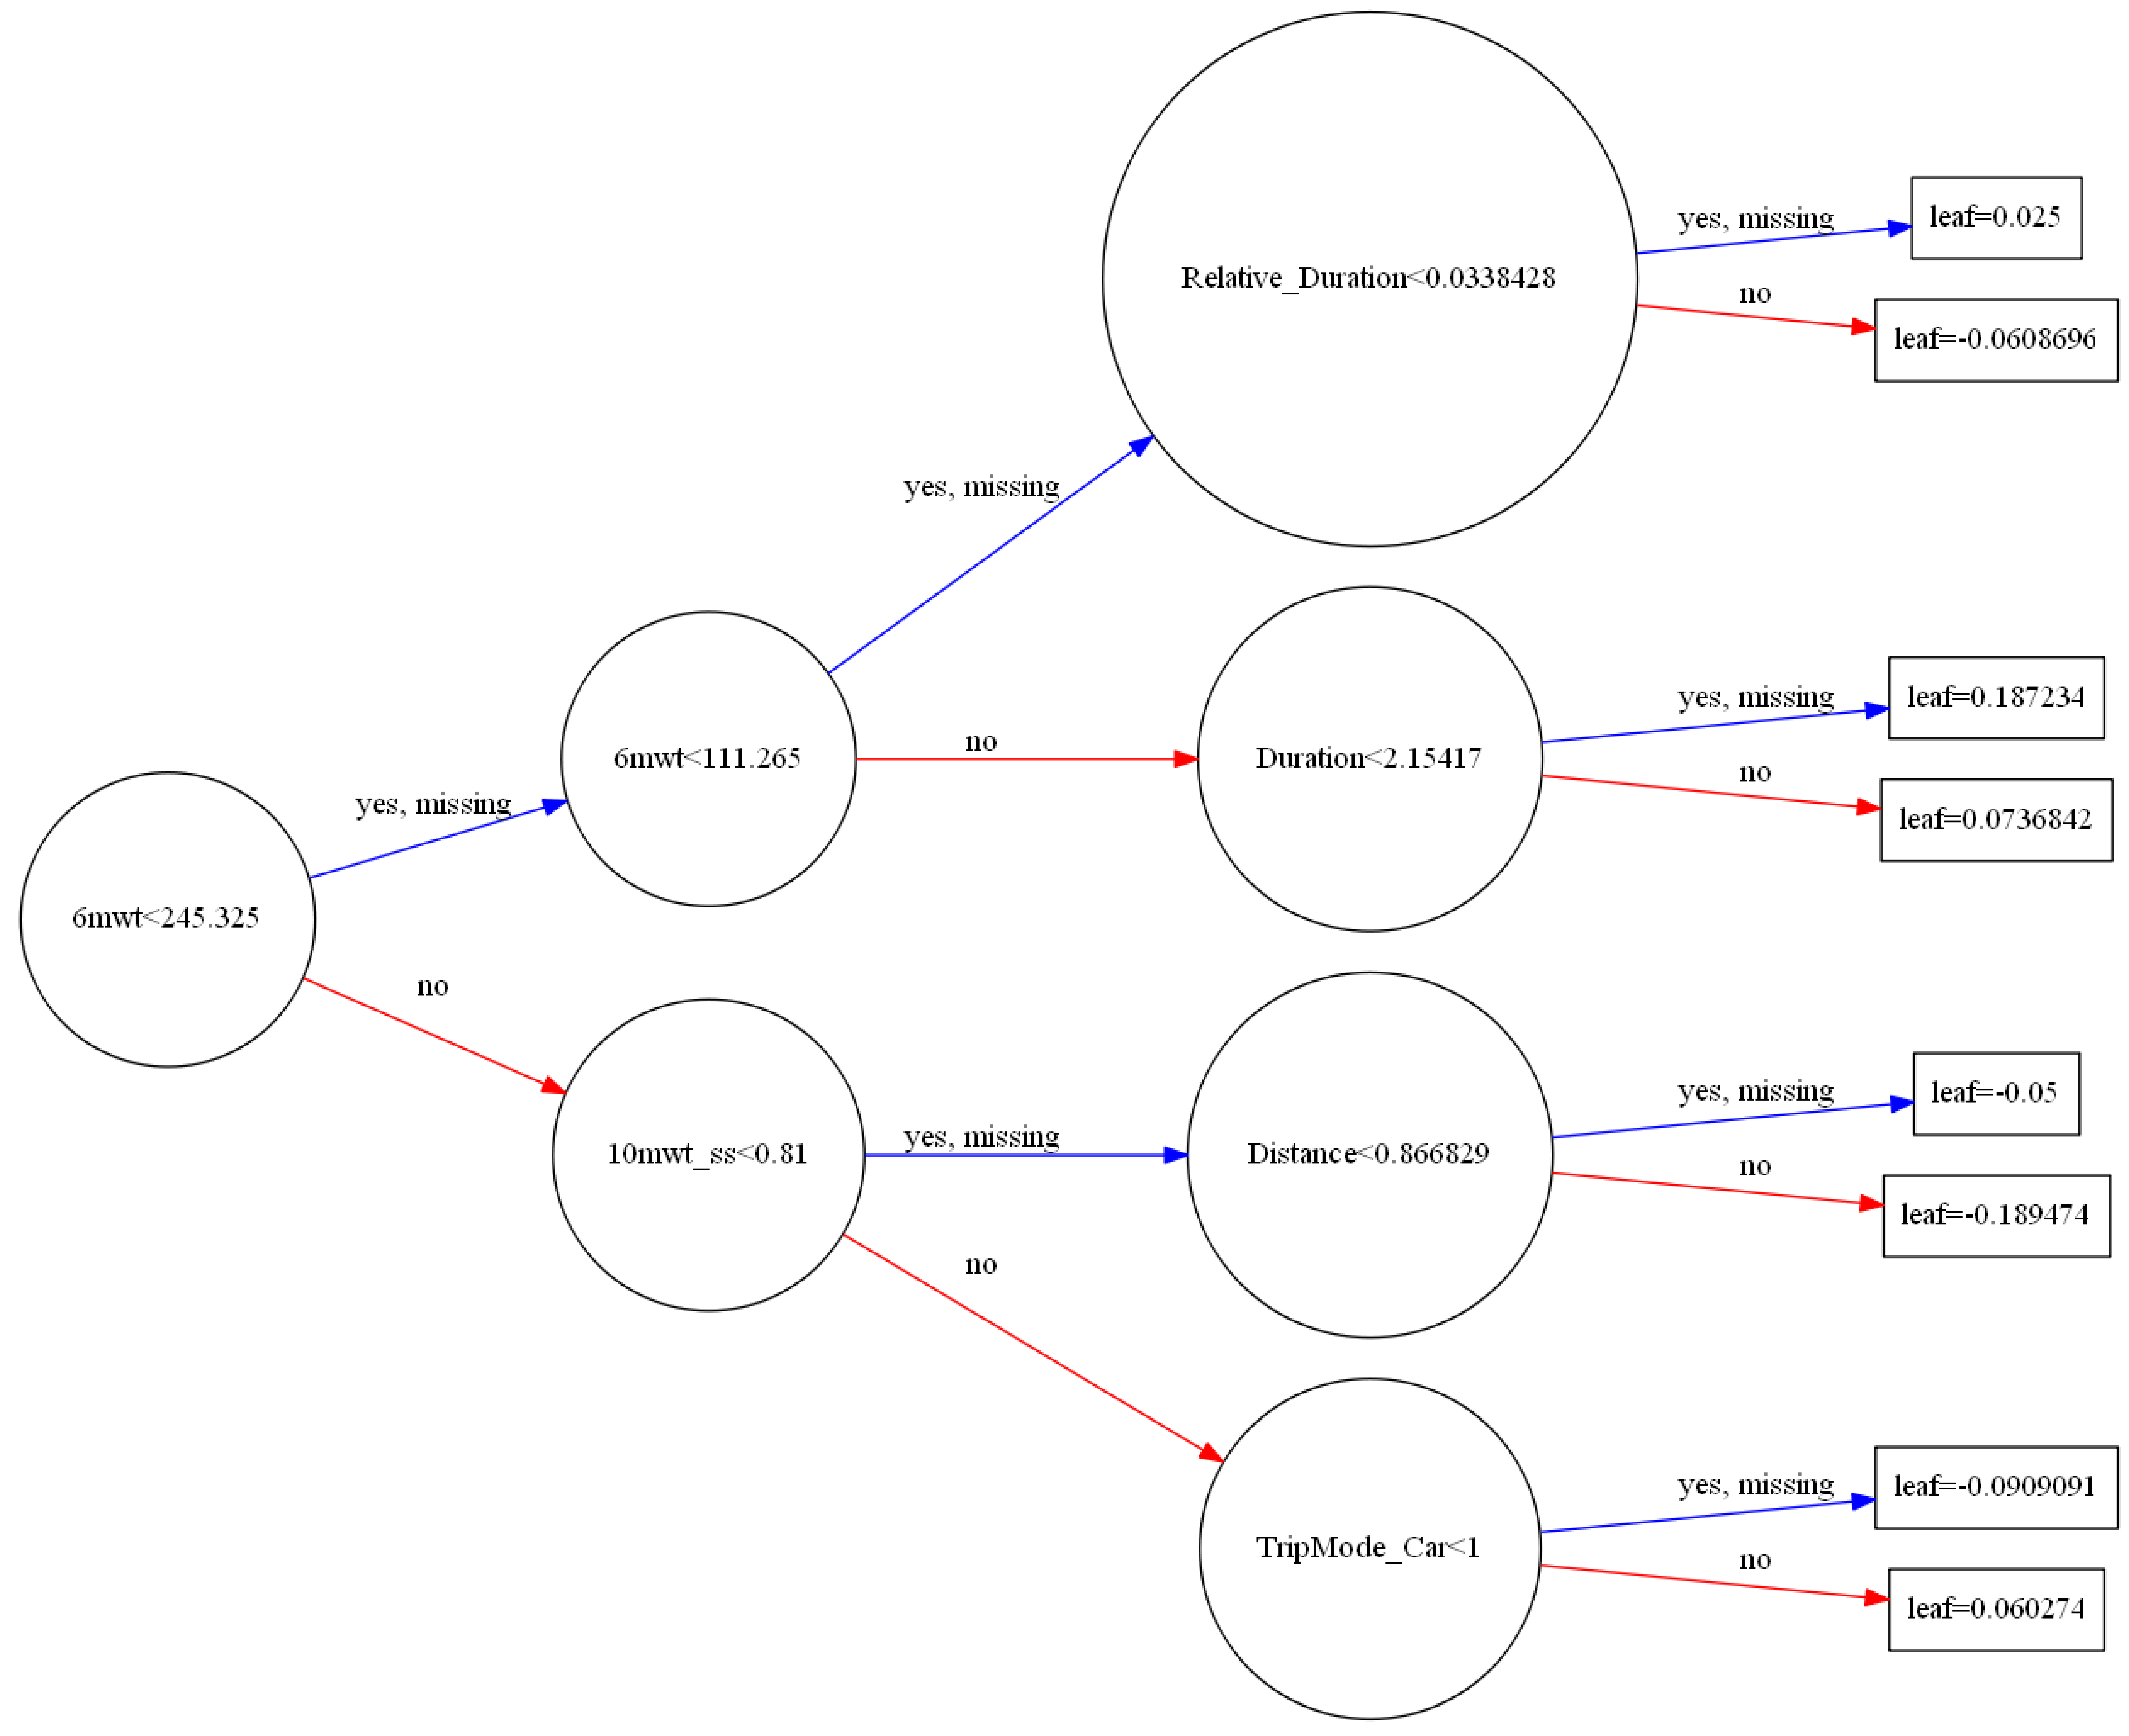

In [85]:
xgb.plot_tree(clf,num_trees=0,rankdir='LR')
# plt.savefig('img/tree.png')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('img/tree0.png')

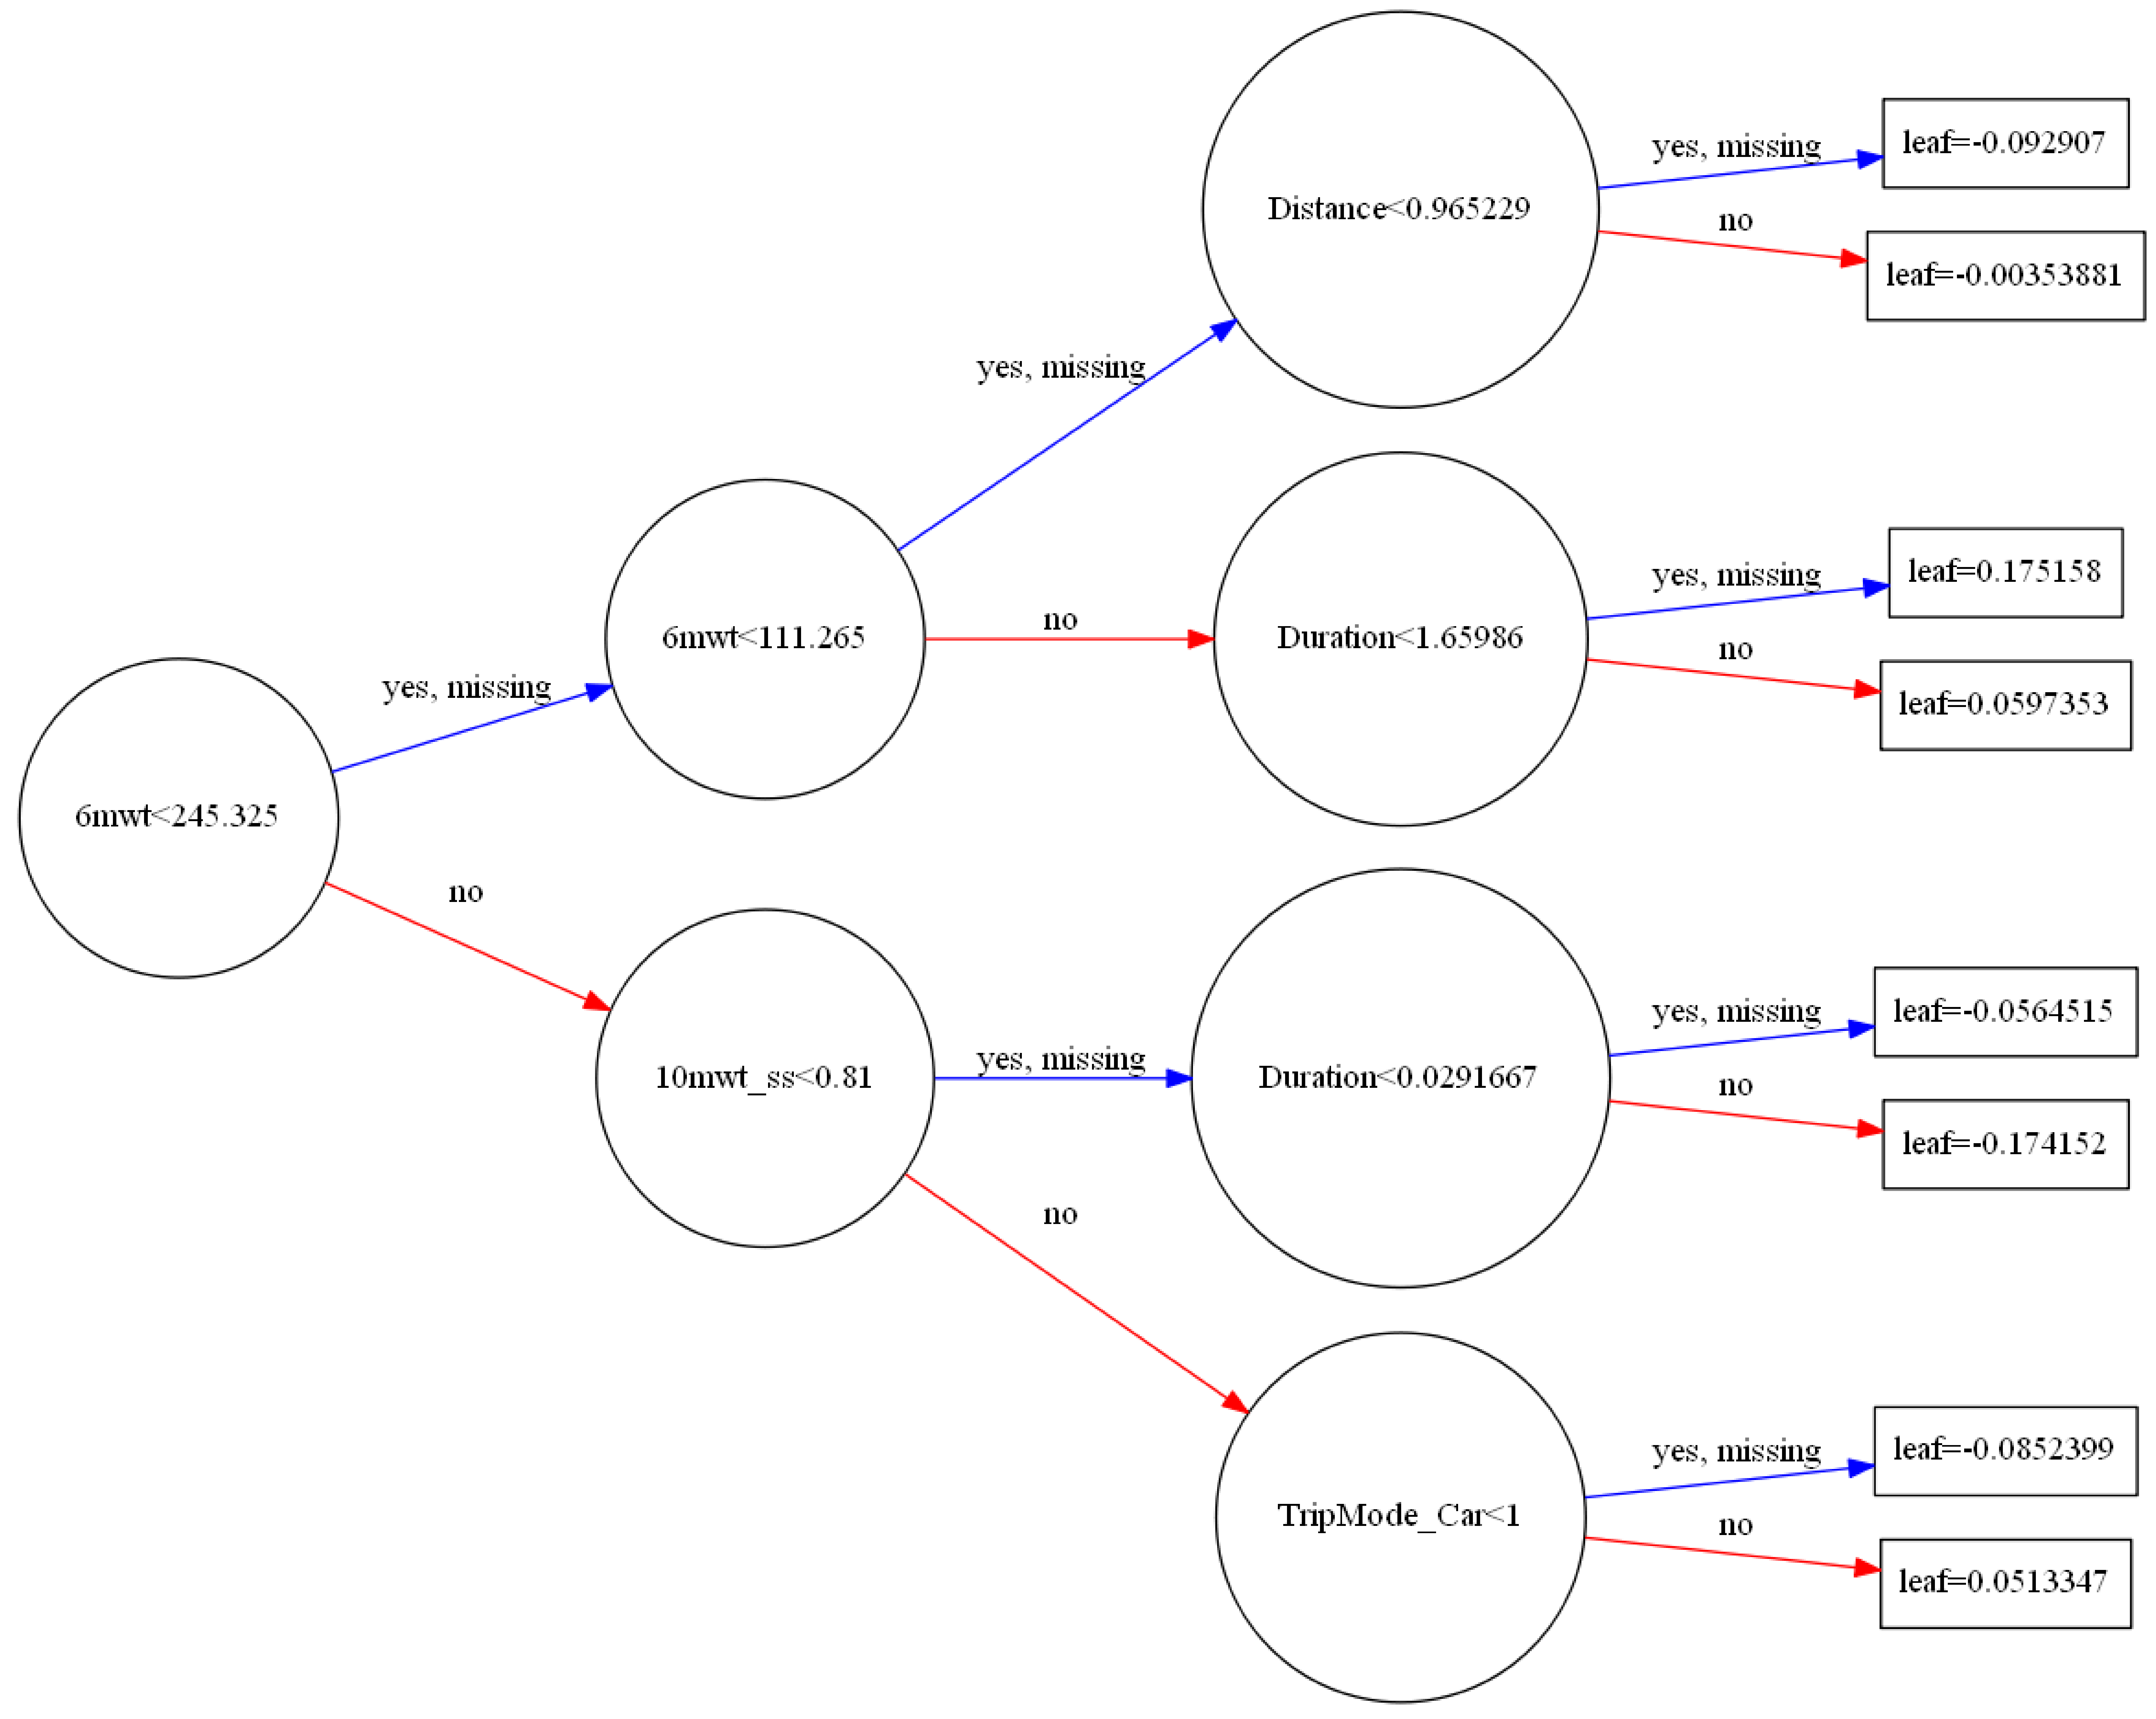

In [86]:
xgb.plot_tree(clf,num_trees=1,rankdir='LR')
# plt.savefig('img/tree.png')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('img/tree1.png')

In [46]:
fimp=pd.DataFrame(fimp_all)

In [131]:
m=fimp.mean()

In [150]:
fh=list(m[m > 10].index)
fh[1]

'6mwt'

In [158]:
for f in fh:
    print(len(clf.get_split_value_histogram(f)))

4
7
2
6
24
38
1
6
11
27


In [156]:
len(clf.get_split_value_histogram(f))

27

## Time spent at home

In [15]:
Data['Brace'].unique()

array(['Cbr', 'Sco', 'Bas'], dtype=object)

In [21]:
durCbr = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durCbr=durCbr[~np.isnan(durCbr)]
durSCO = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durSCO=durSCO[~np.isnan(durSCO)]
durBase = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Bas')]['Duration']
durBase = np.asarray([float(x) for x in durBase.values if type(x) is float])
durBase=durBase[~np.isnan(durBase)]

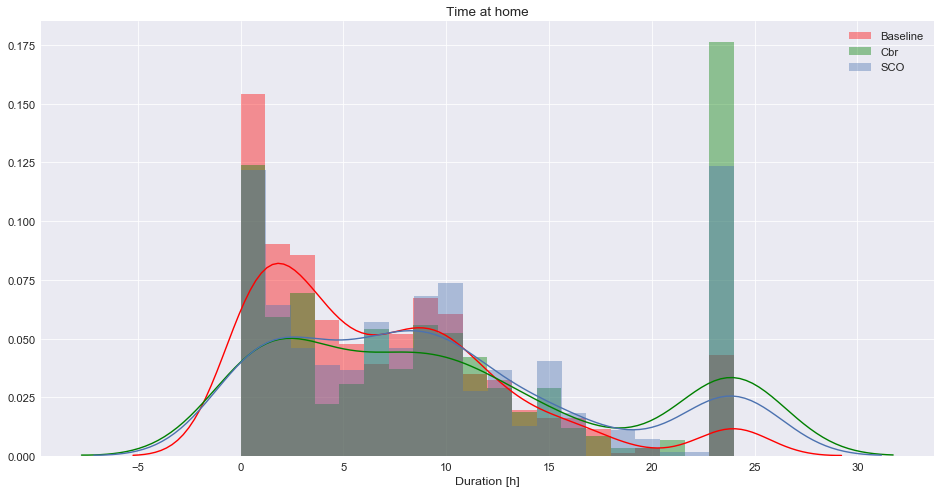

In [22]:
nb = 20
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase/60,color='r',bins=nb)
sns.distplot(durCbr/60,color='g',bins=nb)
sns.distplot(durSCO/60,bins=nb)
plt.xlabel('Duration [h]')
plt.legend(['Baseline','Cbr','SCO'])
plt.title('Time at home')

## Time spent in trips

In [23]:
durCbr = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durSCO = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durBase = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Bas')]['Duration']
durBase = durBase.values.astype(float)

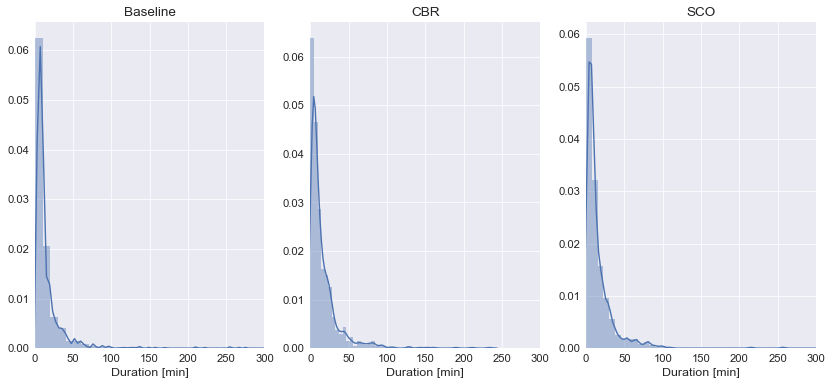

In [24]:
fig = plt.figure(figsize=(14,6))
fig.add_subplot(131)
ax = sns.distplot(durBase)
plt.xlim([0,300])
plt.title('Baseline')
plt.xlabel('Duration [min]')
fig.add_subplot(132)
ax = sns.distplot(durCbr)
plt.xlim([0,300])
plt.title('CBR')
plt.xlabel('Duration [min]')
fig.add_subplot(133)
ax = sns.distplot(durSCO)
plt.xlim([0,300])
plt.title('SCO')
plt.xlabel('Duration [min]')

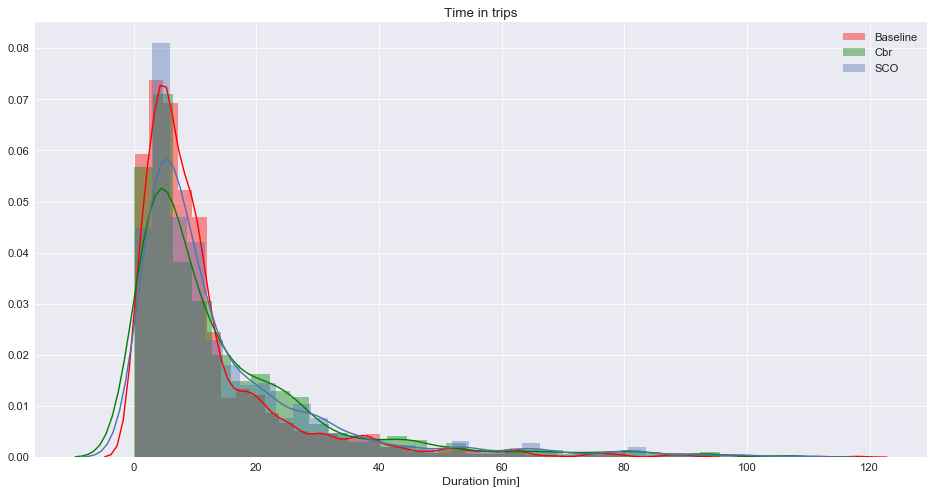

In [25]:
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase[durBase<120],color='r')
sns.distplot(durCbr[durCbr<120],color='g')
sns.distplot(durSCO[durSCO<120])
plt.legend(['Baseline','Cbr','SCO'])
plt.xlabel('Duration [min]')
plt.title('Time in trips')

## Time spent at locations other than home and trip

In [26]:
durCbr = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durSCO = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durBase = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Bas')]['Duration']
durBase = durBase.values.astype(float)

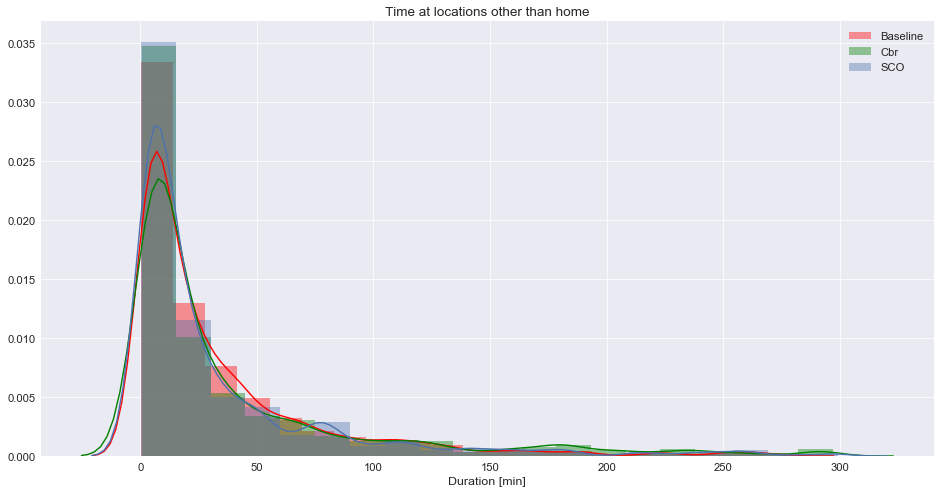

In [27]:
nb = 20
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase[durBase<300],color='r',bins=nb)
sns.distplot(durCbr[durCbr<300],color='g',bins=nb)
sns.distplot(durSCO[durSCO<300],bins=nb)
plt.xlabel('Duration [min]')
plt.legend(['Baseline','Cbr','SCO'])
plt.title('Time at locations other than home')

## Wear Fractions for each brace
* Proportion of trips w/wo brace
* Correlation of wearfrac and Trip duration

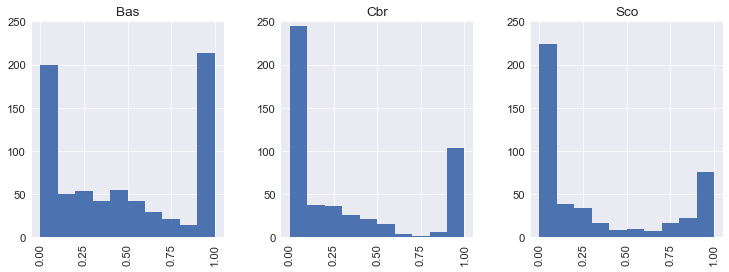

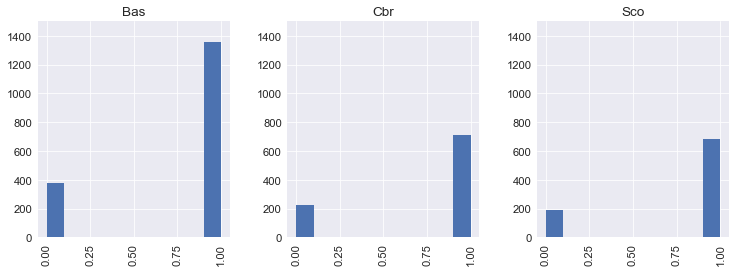

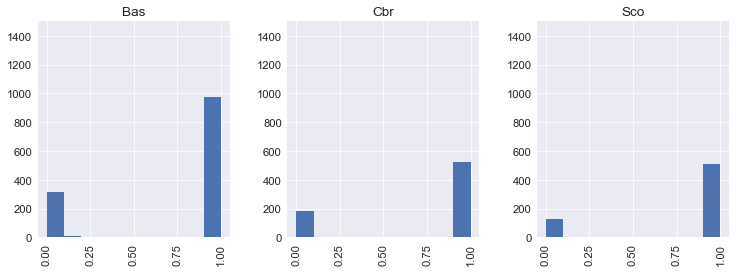

In [126]:
#wearfrac during trips,home and other use
ax = Data[(Data['LandUse']=='Home')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,250])
ax = Data[(Data['LandUse']=='Trip')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,1500])
ax = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,1500])

* Break the information for locations visited (neither home nor trip) by subject

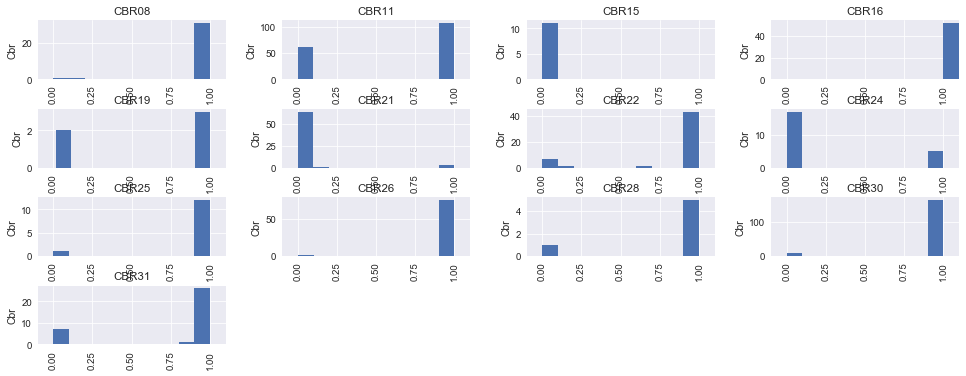

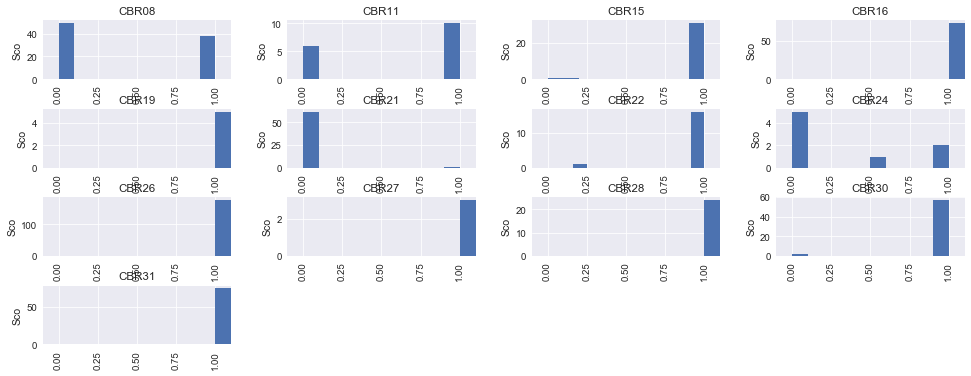

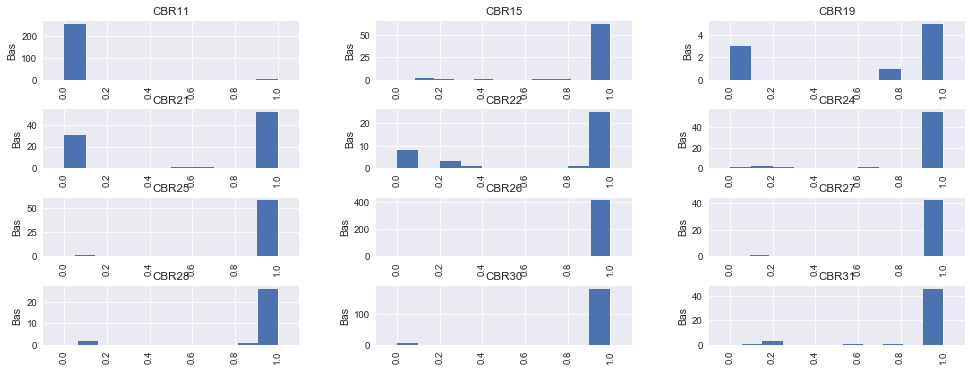

In [194]:
sns.set_context('paper',font_scale=1.2)
for brace in Data['Brace'].unique():
    ax = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']==brace)].hist(column='Wear Frac',by='SubjID',figsize=(16,6))
    for a in ax.reshape(-1):
        a.set_xlim([-0.1,1.1])
        a.set_ylabel(str(brace))

Half subjects were consistent at wearing each brace across all trials. 

# Do people travel further from home with the cbrace?
* Median distance from home with each brace

In [208]:
#plot test datapoint
import gmplot
gmap = gmplot.GoogleMapPlotter(41.75554804, -87.91244198, 16)
gmap.scatter([home[0],home[0]],[home[1],home[1]],'#3B0B39', size=100,marker=False)
gmap.draw("mymap.html")

In [541]:
??gmplot.GoogleMapPlotter

In [ ]:
#store distance of each location visited from home
distall = pd.Series()
for s in Data.SubjID.unique():
    
    #mean lat,lon home for subj
    homelat = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lat'].mean()
    homelon = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lon'].mean()
    Datai = Data.loc[Data['SubjID']==s]            
    print(s)
    #distance of all locations from home
    d = []
    for k in range(len(Datai)):
        lat = Datai.iloc[k]['Mean Lat']
        lon = Datai.iloc[k]['Mean Lon']
        try:
            d.append(vincenty((homelat,homelon),(lat,lon)).meters/1000)
        except(UnboundLocalError): #nan lat,lon
            print('found nan lat/lon')
            d.append(np.nan)
     
    print(len(d))
    
    #aggregate distances for all subjects
    distall = distall.append(pd.Series(data=d,index=Data.loc[Data['SubjID']==s]['SubjID']))

In [90]:
#assigning new index to df Data to match with Series
Data.index = distall.index
Data['DistanceHome'] = distall

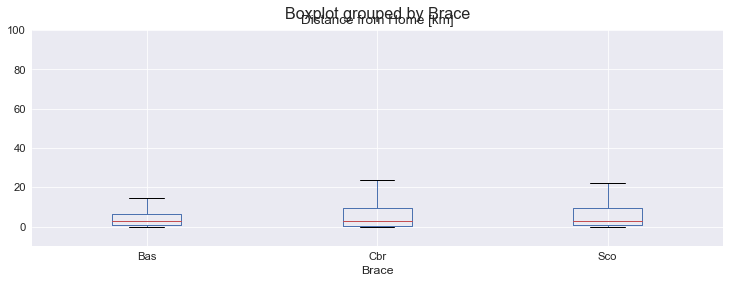

In [103]:
#plot distance from home for locations based on brace
ax2 = Data[~((Data['LandUse']=='Home')&(Data['LandUse']=='Trip'))].boxplot(column='DistanceHome',by='Brace',figsize=(12,4))
ax2.set_ylim([-10,100])
ax2.set_title('Distance from Home [km]')

## Distance traveled from home with each brace

In [ ]:
ax2 = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')&(Data['Wear Frac']>0.75)].boxplot(column='DistanceHome',by=['SubjID'],figsize=(12,4))
ax2.set_ylim([-10,100])
ax2 = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')&(Data['Wear Frac']<0.5)].boxplot(column='DistanceHome',by=['SubjID'],figsize=(12,4))
ax2.set_ylim([-10,100])

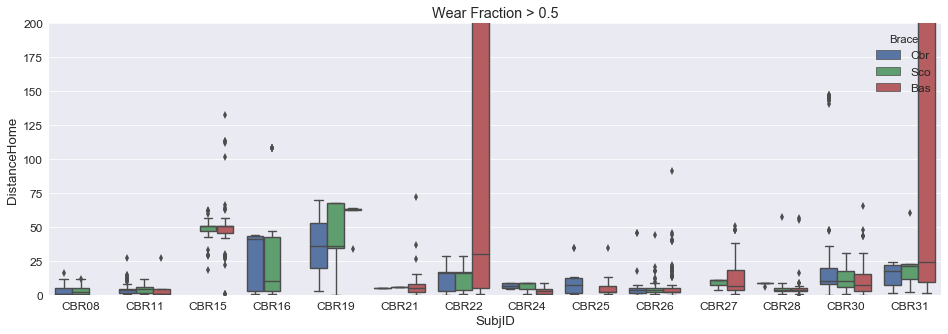

In [203]:
Datalocs = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Wear Frac']>0.5)]
fig = plt.figure(figsize=(16,5))
# fig.add_subplot(211)
ax = sns.boxplot(x='SubjID',y='DistanceHome',hue='Brace',data=Datalocs)
ax.set_ylim([0,200])
plt.title('Wear Fraction > 0.5')
sns.set_context('paper',font_scale=1.5)

# Datalocs = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Wear Frac']<0.5)]
# fig.add_subplot(212)
# ax = sns.boxplot(x='SubjID',y='DistanceHome',hue='Brace',data=Datalocs)
# ax.set_ylim([0,200])
# plt.title('Wear Fraction < 0.5')
# sns.set_context('paper',font_scale=1.5)

In [289]:
#plot locations visited by CBR22 and 31
s = 'CBR22'
d = Data.loc[(Data['SubjID']==s)]#&(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))]
homelat = d[d['LandUse']=='Home']['Mean Lat'].mean()
homelon = d[d['LandUse']=='Home']['Mean Lon'].mean()
gmap = gmplot.GoogleMapPlotter(homelat, homelon, 16)

In [290]:
d = Data.loc[(Data['SubjID']==s)&(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')]
for l in range(len(d)):
    lat = d.iloc[l]['Mean Lat']
    lon = d.iloc[l]['Mean Lon']
    ll = np.array([lat,lon])
    gmap.scatter([ll[0],ll[0]],[ll[1],ll[1]],'#3B0B39', size=200,marker=False)

gmap.draw("mymap.html")

# distinct locations visited per brace

In [11]:
fconv =  os.listdir(path+'GPSWT/')

for f in fconv:
    print(f)
    Data = pd.read_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    # needs to be capitalized to standardize text
    landuse=Data[['LandUse']]
    landuse=landuse.applymap(lambda x: str.capitalize(x))
    Data['LandUse'] = landuse
    
    # find mean Home location
    HomeInd = Data['LandUse']=='Home'
    HomeLon = np.nanmean(Data['Mean Lon'][HomeInd])
    HomeLat = np.nanmean(Data['Mean Lat'][HomeInd])
    
    # identify unique locations (>100m apart)
    
    threshold = 50
    
    UnDestLon = []
    UnDestLat = []
    UnDestDist = []
    
    LocID = []
    DistHome = []
    
    for row in range(len(Data)):
        if (Data['LandUse'][row]!='Home')&(Data['LandUse'][row]!='Trip'): # should be non-Home, non-Trip
            lon = Data['Mean Lon'][row]
            lat = Data['Mean Lat'][row]
            d = vincenty((HomeLat,HomeLon),(lat,lon)).meters
            DistHome.append(d)
            if d<=threshold:
                # Ideally, d threshold should be small enough to separate locations near home
                # Flag failures to do this for now to see how often it happens
                print('Error: Non-Home Destination Near Home')
                print(Data['LandUse'][row])
                print(d)
                LocID.append(-2)
            else:
                if len(UnDestLon)<1: # Initial destination
                    UnDestLon.append(lon); UnDestLat.append(lat)
                    LocID.append(1)
                else: # After first location is ID'd check to see if other destinations are unique
                    i = 0; Unlabeled = True
                    while Unlabeled & (i<len(UnDestLat)):
                        d = vincenty((UnDestLat[i],UnDestLon[i]),(lat,lon)).meters
                        if d<=threshold:
                            Unlabeled = False
                            LocID.append(i+1)
                            # may want to consider adjusting mean location for the destination based on new trip
                        else:
                            i=i+1
                    if i==len(UnDestLat):
                        UnDestLon.append(lon); UnDestLat.append(lat); UnDestDist.append(d)
                        LocID.append(i+1)
        else:
            # Special cases for Home and Trip data
            if Data['LandUse'][row]=='Home':
                LocID.append(0)
                DistHome.append(0)
            else:
                LocID.append(-1)
                DistHome.append(-1)
                
    Data['LocID'] = pd.Series(LocID)
    Data['DistHome']  = pd.Series(DistHome)
    
    Data.to_csv(path+'UIC_GPSData/w_LocIDandDist/'+f)
                    
                            
                        
                    
    

CBR08_CBrace.csv
CBR08_SCO.csv
CBR11_Baseline.csv
CBR11_CBrace.csv
CBR11_SCO.csv
CBR15_Baseline.csv
CBR15_CBrace.csv
CBR15_SCO.csv
CBR16_CBrace.csv
CBR16_SCO.csv
CBR19_Baseline.csv
CBR19_CBrace.csv
CBR19_SCO.csv
Error: Non-Home Destination Near Home
Com_regional
9.55765950374758
CBR21_Baseline.csv
CBR21_CBrace.csv
CBR21_SCO.csv
CBR22_Baseline.csv
CBR22_CBrace.csv
CBR22_SCO.csv
CBR24_Baseline.csv
CBR24_CBrace.csv
CBR24_SCO.csv
CBR25_Baseline.csv
CBR25_CBrace.csv
CBR26_Baseline.csv
CBR26_CBrace.csv
CBR26_SCO.csv
CBR27_Baseline.csv
CBR27_CBrace.csv
CBR27_SCO.csv
CBR28_Baseline.csv
CBR28_CBrace.csv
CBR28_SCO.csv
CBR30_Baseline.csv
CBR30_CBrace.csv
CBR30_SCO.csv
CBR31_Baseline.csv
CBR31_CBrace.csv
CBR31_SCO.csv
